In [1]:
library(tidyverse)
library(patchwork)
source("gene_track_plots.R")
source("helpers.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.2     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose




In [2]:
transcripts <- read_tsv("example_data/transcripts.tsv")
protein_domains <- read_tsv("example_data/domains.tsv") %>%
    select(-c(blockCount, score))


── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_character(),
  ensembl_version = col_double(),
  chrom = col_double(),
  feature_start = col_double(),
  feature_end = col_double(),
  frame = col_double(),
  gene_version = col_double(),
  transcript_version = col_double(),
  transcript_support_level = col_double(),
  exon_version = col_double(),
  exon_number = col_double(),
  protein_id = col_logical(),
  protein_version = col_logical()
)
ℹ Use `spec()` for the full column specifications.



── Column specification ────────────────────────────────────────────────────────
cols(
  chrom = col_double(),
  strand = col_character(),
  name = col_character(),
  score = col_double(),
  blockCount = col_double(),
  feature_unique_identifier = col_character(),
  start = col_double(),
  end = col_double(),
  sub_track = col_character(),
  jstart = col_double(),
  jend = col_double()
)




In [3]:
protein_domains %>%
    # Each row is a genomic region coding for a "domain" with a given name

    # To distinguish two distinct domains coming from different regions of the genome
    # (or different regions of the same protein), use feature_unique_identifier
    # for e.g., here are two RNA binding domains, RRM_1, with the same name
    # to distinguish them, use the feature_unique_identifier column (1343_RRM_1 vs 1344_RRM_1)
    
    # The jstart and jend indicate that there is an exon-exon
    # splice junction connecting two genomic regions. For example, 1344_RRM_1 is encoded
    # by two exons, spliced together by the 35190995-35191340 junction

    # 1343_RRM_1 is encoded within one exon, so there is splice junction

    # note that these coordinates are 1-based (they come from UCSC)
    head(6)

chrom,strand,name,feature_unique_identifier,start,end,sub_track,jstart,jend
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
1,-,NOPS,1342_NOPS,35189312,35189382,ucsc_pfam_domains,35189382,35190497
1,-,NOPS,1342_NOPS,35190497,35190583,ucsc_pfam_domains,NA,NA
1,-,RRM_1,1343_RRM_1,35190713,35190893,ucsc_pfam_domains,NA,NA
1,-,RRM_1,1344_RRM_1,35190923,35190995,ucsc_pfam_domains,35190995,35191340
1,-,RRM_1,1344_RRM_1,35191340,35191463,ucsc_pfam_domains,NA,NA
1,+,zf-FCS,1345_zf-FCS,35370450,35370565,ucsc_pfam_domains,NA,NA


In [4]:
# each row is an exon from a given transcript
# here shoing the MANE transcript of IL6R with 10 exons
transcripts %>%
    filter(transcript_id == "ENST00000368485") %>%
    select(feature, feature_start, feature_end, transcript_id, gene_name, strand, exon_number) %>%
    arrange(feature_start) %>%
    # this function adds jstart and jend, the exon-exon junction coordinates beween each exon
    # this function also auto-renames feature_start to start and feature_end to end...
    add_introns(exon_col_start = "feature_start", exon_col_end = "feature_end", groupby = "transcript_id")

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(exon_col_start)` instead of `exon_col_start` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(exon_col_end)` instead of `exon_col_end` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



feature,start,end,transcript_id,gene_name,strand,exon_number,jstart,jend
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
exon,154405343,154405714,ENST00000368485,IL6R,+,1,154405714,154429196
exon,154429196,154429444,ENST00000368485,IL6R,+,2,154429444,154430483
exon,154430483,154430606,ENST00000368485,IL6R,+,3,154430606,154434519
exon,154434519,154434700,ENST00000368485,IL6R,+,4,154434700,154434990
exon,154434990,154435156,ENST00000368485,IL6R,+,5,154435156,154435969
exon,154435969,154436110,ENST00000368485,IL6R,+,6,154436110,154448125
exon,154448125,154448171,ENST00000368485,IL6R,+,7,154448171,154449911
exon,154449911,154449980,ENST00000368485,IL6R,+,8,154449980,154454488
exon,154454488,154454581,ENST00000368485,IL6R,+,9,154454581,154465134


In [5]:
# find overlaps between two sets of genomic ranges
ov_list <- list()
# for each chromosome
for (chr in 
        intersect(unique(transcripts$chrom), unique(protein_domains$chrom))
    ) {
    # for each strand
    for (stra in c("+", "-")) {
        chr_strand <- paste0(chr, stra)
        # find overlaps for this chromosome & strand combination
        ov_list[[`chr_strand`]] <- find_overlaps(
                protein_domains %>%
                    filter(chrom == chr, strand == stra) %>%
                    # convert UCSC 1 based to 0 based index
                    mutate(start = start + 1),
                # overlap protein domains within all unique exon starts and ends
                # (annotated exons from transcripts in Ensembl for e.g.)
                transcripts %>%
                    rename(
                        start = feature_start,
                        end = feature_end
                    ) %>%
                    filter(chrom == chr, strand == stra) %>%
                    select(start, end, gene_name) %>%
                    group_by(gene_name) %>%
                    distinct()
            ) %>%
            rename(
                domain_name = name,
                domain_start = start,
                domain_end = end,
                domain_source = sub_track
            ) %>%
            ungroup()
    }
}
gene_mapped_domains <- bind_rows(ov_list)
# now we have mapped which protein domain genomic ranges were within exon genomic ranges, 
# preserving the gene_name 
head(gene_mapped_domains)
dim(gene_mapped_domains)

gene_name,chrom,strand,domain_name,feature_unique_identifier,domain_start,domain_end,domain_source,jstart,jend
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
CD44,11,+,Signal peptide,680162_Signal peptide,35139304,35139363,ucsc_uniprot_signalpeptide,NA,NA
CD44,11,+,E9PKC6,157127_E9PKC6,35139304,35139370,ucsc_uniprot_alitrembl,35139370,35176574
CD44,11,+,Q86UZ1,157128_Q86UZ1,35139304,35139370,ucsc_uniprot_alitrembl,35139370,35176574
CD44,11,+,A0A385KNS5,157129_A0A385KNS5,35139304,35139370,ucsc_uniprot_alitrembl,35139370,35176574
CD44,11,+,A8K309,157130_A8K309,35139304,35139370,ucsc_uniprot_alitrembl,35139370,35176574
CD44,11,+,B4DN59,157131_B4DN59,35139304,35139370,ucsc_uniprot_alitrembl,35139370,35176574


[1] 1065   10

In [6]:
# example, take a look at the exon feature_start and feature_ends in this transcript
transcripts %>%
    filter(transcript_id == "ENST00000622330") %>%
    arrange(feature_start) %>%
    select(feature_start, feature_end, exon_number)

feature_start,feature_end,exon_number
<dbl>,<dbl>,<dbl>
154405193,154405714,1
154429196,154429444,2
154430483,154430606,3
154434519,154434700,4
154434990,154435156,5
154435969,154436110,6
154437435,154437544,7


In [7]:
# we can see that the Signal peptide genomic range is indeed within the exon 1 genomic range above
gene_mapped_domains %>%
        filter(gene_name =="IL6R", domain_name == "Signal peptide") %>%
        mutate(start = domain_start, end = domain_end) %>%
        arrange(start)

gene_name,chrom,strand,domain_name,feature_unique_identifier,domain_start,domain_end,domain_source,jstart,jend,start,end
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
IL6R,1,+,Signal peptide,677385_Signal peptide,154405630,154405686,ucsc_uniprot_signalpeptide,NA,NA,154405630,154405686


In [8]:
il6r_domains_example_tb <-
gene_mapped_domains %>%
    filter(gene_name =="IL6R") %>%
    # plot_tracks expects `start` and `end` columns
    mutate(start = domain_start, end = domain_end)

dim(il6r_domains_example_tb)
head(il6r_domains_example_tb)

[1] 109  12

gene_name,chrom,strand,domain_name,feature_unique_identifier,domain_start,domain_end,domain_source,jstart,jend,start,end
<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
IL6R,1,+,Signal peptide,677385_Signal peptide,154405630,154405686,ucsc_uniprot_signalpeptide,NA,NA,154405630,154405686
IL6R,1,+,D6R9R8,148880_D6R9R8,154405630,154405714,ucsc_uniprot_alitrembl,154405714,154429195,154405630,154405714
IL6R,1,+,A0A087WTB5,148881_A0A087WTB5,154405630,154405714,ucsc_uniprot_alitrembl,154405714,154429195,154405630,154405714
IL6R,1,+,A0N0L5,148882_A0N0L5,154405630,154405714,ucsc_uniprot_alitrembl,154405714,154429195,154405630,154405714
IL6R,1,+,P08887-1,356454_P08887-1,154405630,154405714,ucsc_uniprot_alitswissprot,154405714,154429195,154405630,154405714
IL6R,1,+,Extracellular,473366_Extracellular,154405687,154405714,ucsc_uniprot_extracellular,154405714,154429195,154405687,154405714


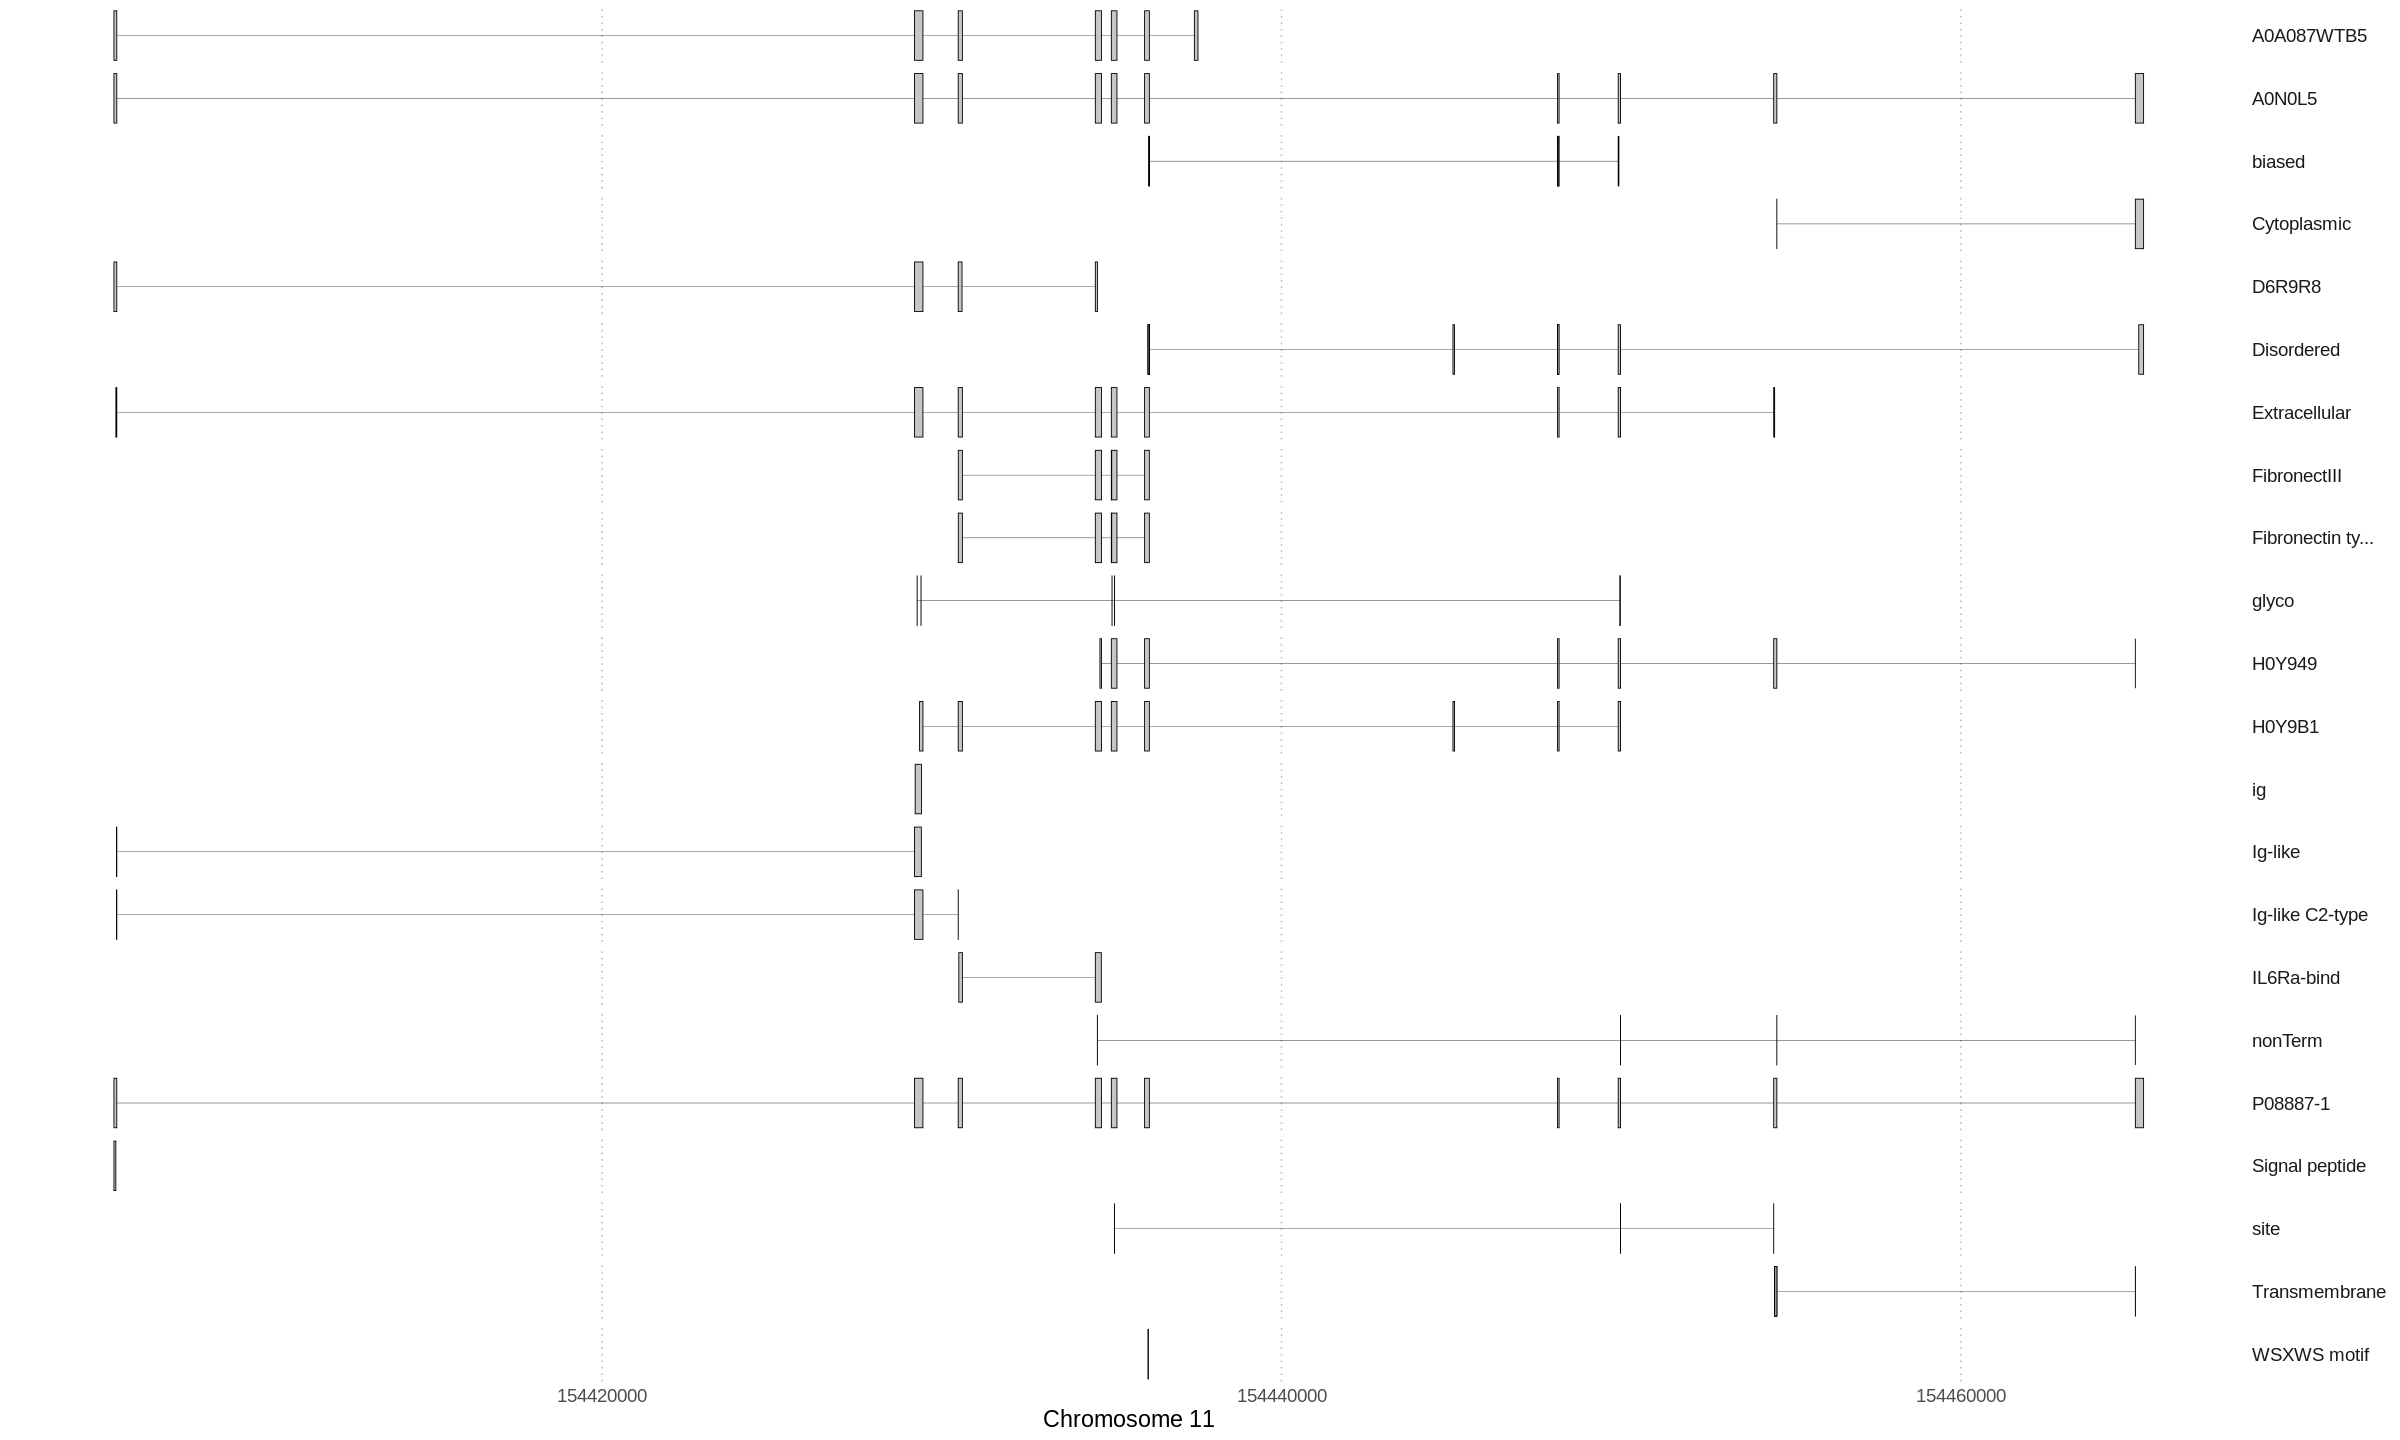

In [9]:
options(repr.plot.width=20, repr.plot.height=12)

domain_track_p <-
plot_tracks(
    # let's plot the protein domains we mapped to IL6R exons:
    il6r_domains_example_tb,
    # need to specify the strand (we know this is a + strand gene)
    # because this function always plots elements 5' to 3'
    #(+ strand genes will show increasing genomic coord left to right)
    #(- strand genes will show decreasing genomic coord left to right)
    strand = "+",
    # X axis label
    seqid = "Chromosome 11",
    # Use the jstart and jend columns to add splice-junctions between the same feature_unique_identifiers
    add_connections = T,
    # Each row corresponds to a distinct domain_name (can have distinct feature_unique_identifiers)
    facet_wrap_by = "domain_name",
    # width of the splice junctions
    intron_width=0.1
)  +
# ggplot2::facet_wrap(
#     ~domain_name,
#     ncol = 1,
#     strip.position = "right"
# ) +
theme(
    # increase font size of the facet labels
    text = element_text(size = 14),
    # make facet labels on left justified
    strip.text = element_text(hjust = 0),
    # remove background color from facet label boxes
    strip.background = element_rect(colour = "white",
                                    fill = "white"))

domain_track_p

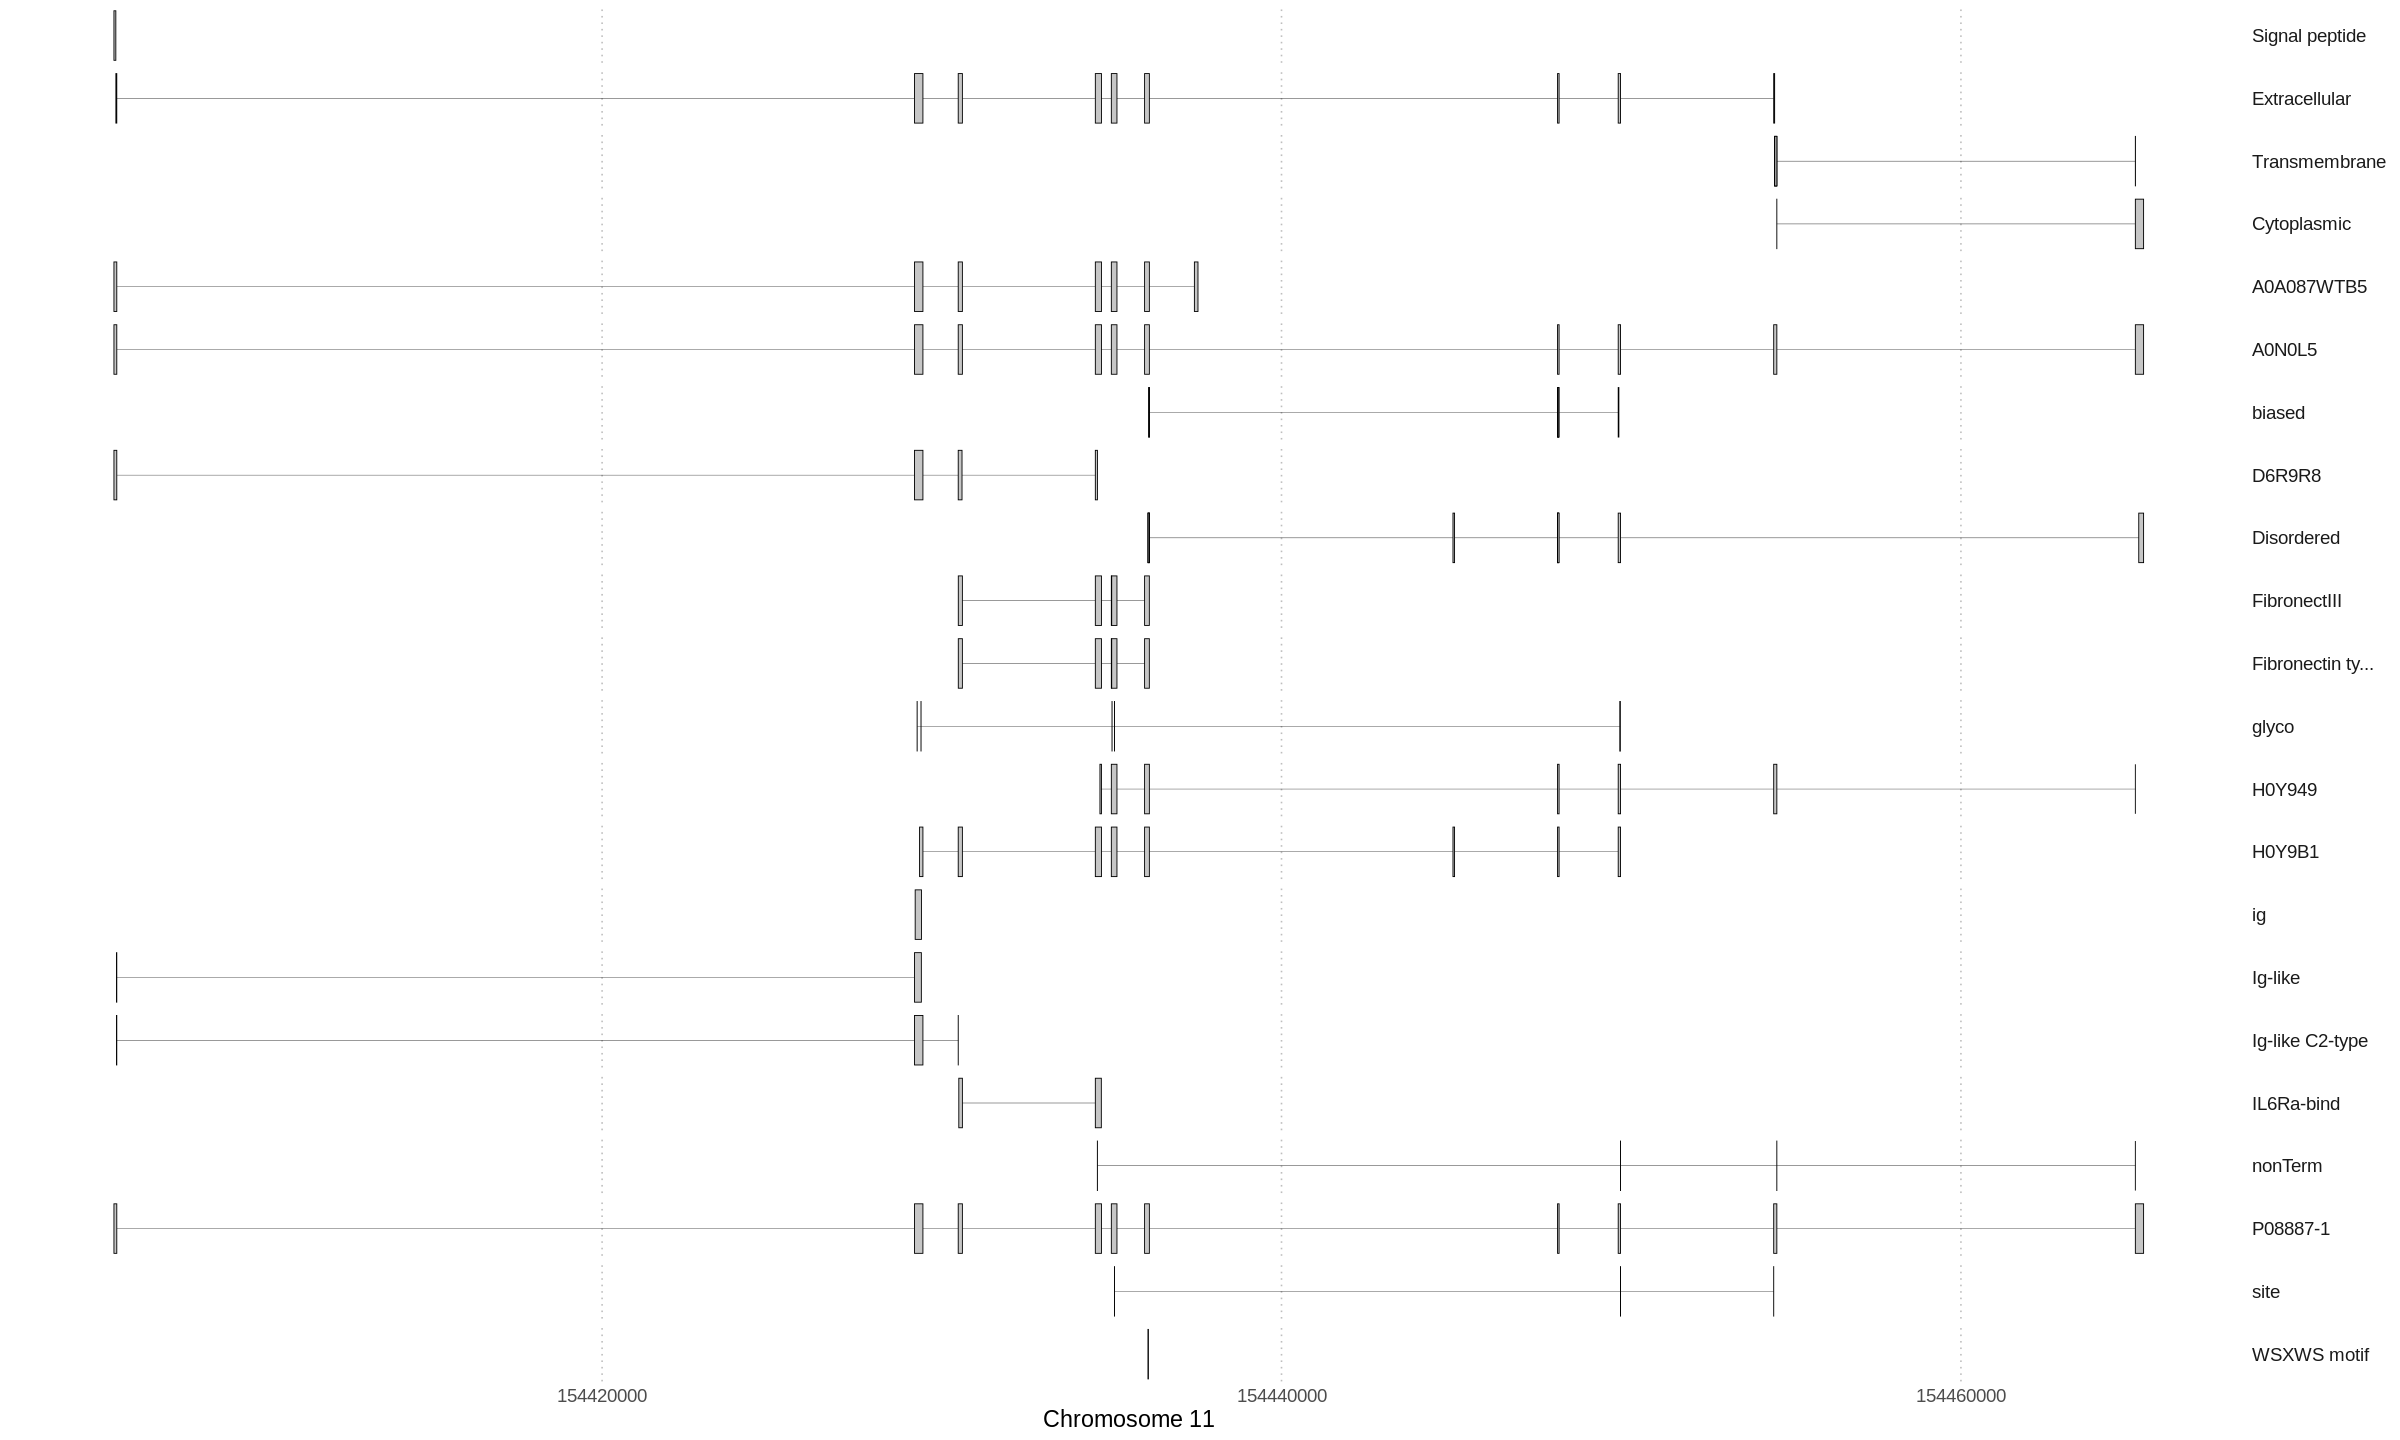

In [10]:
# Let's reorder the domains

domains_to_reorder <- sort(unique(il6r_domains_example_tb$domain_name))

# put these domains at the top, in this order
priority_tracks <- c(
        "enzyme act site",
        "Signal peptide",
        "Extracellular",
        "Transmembrane",
        "Cytoplasmic"
    )
priority_tracks_wehave <- priority_tracks[priority_tracks %in% domains_to_reorder]

il6r_domains_example_tb$domain_name <- factor(
    il6r_domains_example_tb$domain_name,
    levels = c(
        priority_tracks,
        # all the other domains will be alphabetical
        sort(setdiff(domains_to_reorder, priority_tracks))
    )
)

options(repr.plot.width=20, repr.plot.height=12)

domain_track_p <-
plot_tracks(
    il6r_domains_example_tb,
    strand = "+",
    seqid = "Chromosome 11",
    add_connections = T,
    facet_wrap_by = "domain_name",
    intron_width=0.1
)  +
theme(
    text = element_text(size = 14),
    strip.text = element_text(hjust = 0),
    strip.background = element_rect(colour = "white",
                                    fill = "white"))

# now we see the priority tracks at the top!
domain_track_p

In [11]:
il6r_transcripts_example_tb <-
transcripts %>%
    filter(gene_name == "IL6R") %>%
    select(feature, feature_start, feature_end, transcript_id, gene_name, strand, transcript_support_level, transcript_biotype) %>%
    arrange(feature_start) %>%
    # this function adds jstart and jend, the exon-exon junction coordinates beween each exon
    add_introns(exon_col_start = "feature_start", exon_col_end = "feature_end", groupby = "transcript_id") %>%
    dplyr::rename(tsl = transcript_support_level) %>%
    dplyr::mutate(
        tsl = paste0("tsl", tsl),
        simplified_biotype = ifelse(transcript_biotype == "protein_coding", "cod", transcript_biotype),
        simplified_biotype = ifelse(simplified_biotype == "nonsense_mediated_decay", "nmd", simplified_biotype),
        simplified_biotype = ifelse(simplified_biotype %in% c("cod", "nmd"), simplified_biotype, "oth"),
        transcript_label = factor(stringr::str_c(transcript_id, ",", tsl, ",", simplified_biotype))
    )

dim(il6r_transcripts_example_tb)
head(il6r_transcripts_example_tb %>% arrange(transcript_id, start), 12)

[1] 51 12

feature,start,end,transcript_id,gene_name,strand,tsl,transcript_biotype,jstart,jend,simplified_biotype,transcript_label
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<fct>
exon,154405223,154405714,ENST00000344086,IL6R,+,tsl1,protein_coding,154405714,154429196,cod,"ENST00000344086,tsl1,cod"
exon,154429196,154429444,ENST00000344086,IL6R,+,tsl1,protein_coding,154429444,154430483,cod,"ENST00000344086,tsl1,cod"
exon,154430483,154430606,ENST00000344086,IL6R,+,tsl1,protein_coding,154430606,154434519,cod,"ENST00000344086,tsl1,cod"
exon,154434519,154434700,ENST00000344086,IL6R,+,tsl1,protein_coding,154434700,154434990,cod,"ENST00000344086,tsl1,cod"
exon,154434990,154435156,ENST00000344086,IL6R,+,tsl1,protein_coding,154435156,154435969,cod,"ENST00000344086,tsl1,cod"
exon,154435969,154436110,ENST00000344086,IL6R,+,tsl1,protein_coding,154436110,154448125,cod,"ENST00000344086,tsl1,cod"
exon,154448125,154448171,ENST00000344086,IL6R,+,tsl1,protein_coding,154448171,154449911,cod,"ENST00000344086,tsl1,cod"
exon,154449911,154449980,ENST00000344086,IL6R,+,tsl1,protein_coding,154449980,154465134,cod,"ENST00000344086,tsl1,cod"
exon,154465134,154466877,ENST00000344086,IL6R,+,tsl1,protein_coding,NA,NA,cod,"ENST00000344086,tsl1,cod"


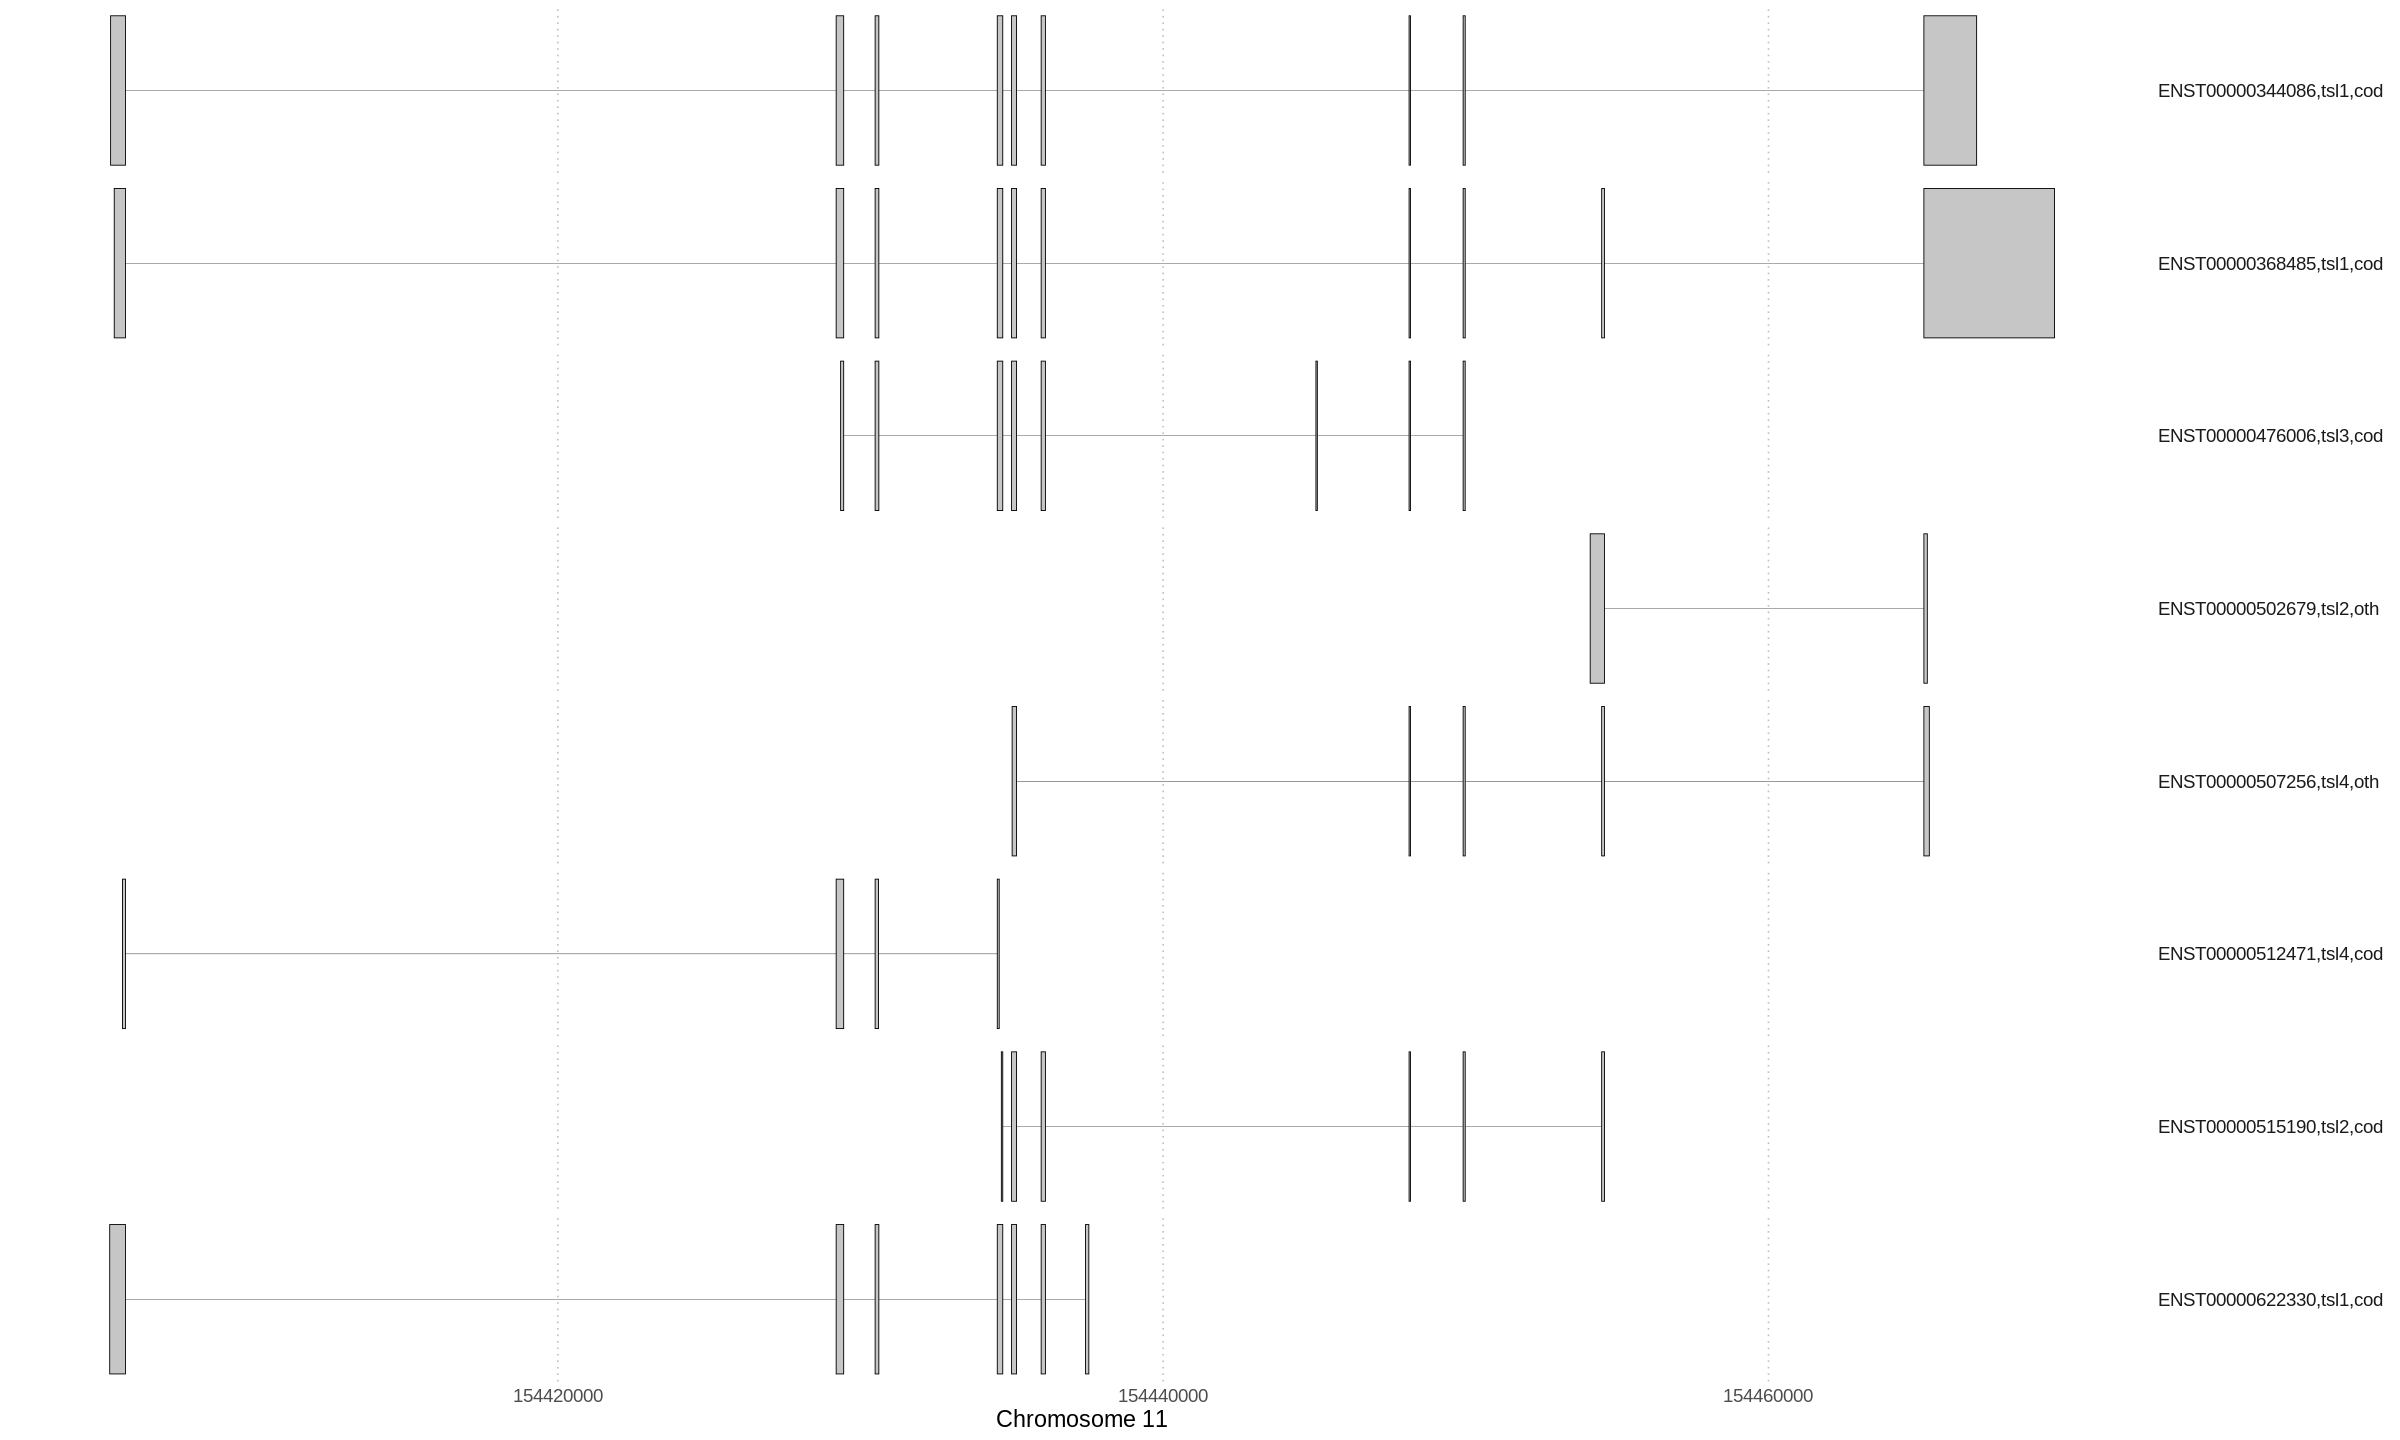

In [12]:
options(repr.plot.width=20, repr.plot.height=12)


preferred_tx_biotype_order <- c(
    "protein_coding",
    "nonsense_mediated_decay",
    "non_stop_decay",
    "antisense",
    "retained_intron",
    "ribozyme",
    "non_coding",
    "sense_intronic",
    "sense_overlapping",
    "TEC",
    "rRNA_pseudogene",
    "miRNA",
    "rRNA",
    "vaultRNA",
    "misc_RNA",
    "antisense_RNA",
    "sRNA",
    "scRNA",
    "macro_lncRNA",
    "bidirectional_promoter_lncRNA",
    "bidirectional_promoter_lncrna",
    "snoRNA",
    "snRNA",
    "scaRNA",
    "3prime_overlapping_ncRNA",
    "vault_RNA",
    "lincRNA",
    "3prime_overlapping_ncrna",
    "Mt_rRNA",
    "Mt_tRNA",
    "lncRNA",
    "IG_D_gene",
    "IG_J_gene",
    "IG_C_gene",
    "IG_V_gene",
    "IG_V_pseudogene",
    "IG_C_pseudogene",
    "IG_J_pseudogene",
    "IG_pseudogene",
    "TR_J_gene",
    "TR_D_gene",
    "TR_V_gene",
    "TR_J_pseudogene",
    "TR_C_gene",
    "TR_V_pseudogene",
    "processed_transcript",
    "pseudogene",
    "transcribed_unitary_pseudogene",
    "transcribed_unprocessed_pseudogene",
    "polymorphic_pseudogene",
    "unitary_pseudogene",
    "translated_processed_pseudogene",
    "unprocessed_pseudogene",
    "transcribed_processed_pseudogene",
    "processed_pseudogene",
    "translated_unprocessed_pseudogene"
)



# Let's plot the transcripts plot, with some extra info
transcript_p <-
plot_tracks(
    il6r_transcripts_example_tb,
    strand = "+",
    seqid = "Chromosome 11",
    add_connections = T,
    facet_wrap_by = "transcript_label",
    intron_width=0.1
)  +
theme(
    text = element_text(size = 14),
    strip.text = element_text(hjust = 0),
    strip.background = element_rect(colour = "white",
                                    fill = "white"))

transcript_p

In [13]:
head(il6r_domains_example_tb, 3) %>%
    rename(feature_name = domain_name) %>%
    select(feature_name, start, end, strand, jstart, jend)

feature_name,start,end,strand,jstart,jend
<fct>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
Signal peptide,154405630,154405686,+,NA,NA
D6R9R8,154405630,154405714,+,154405714,154429195
A0A087WTB5,154405630,154405714,+,154405714,154429195


In [14]:
head(il6r_transcripts_example_tb, 3) %>%
    rename(feature_name = transcript_label) %>%
    select(feature_name, start, end, strand, jstart, jend)

feature_name,start,end,strand,jstart,jend
<fct>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
"ENST00000344086,tsl1,cod",154405223,154405714,+,154405714,154429196
"ENST00000344086,tsl1,cod",154429196,154429444,+,154429444,154430483
"ENST00000344086,tsl1,cod",154430483,154430606,+,154430606,154434519


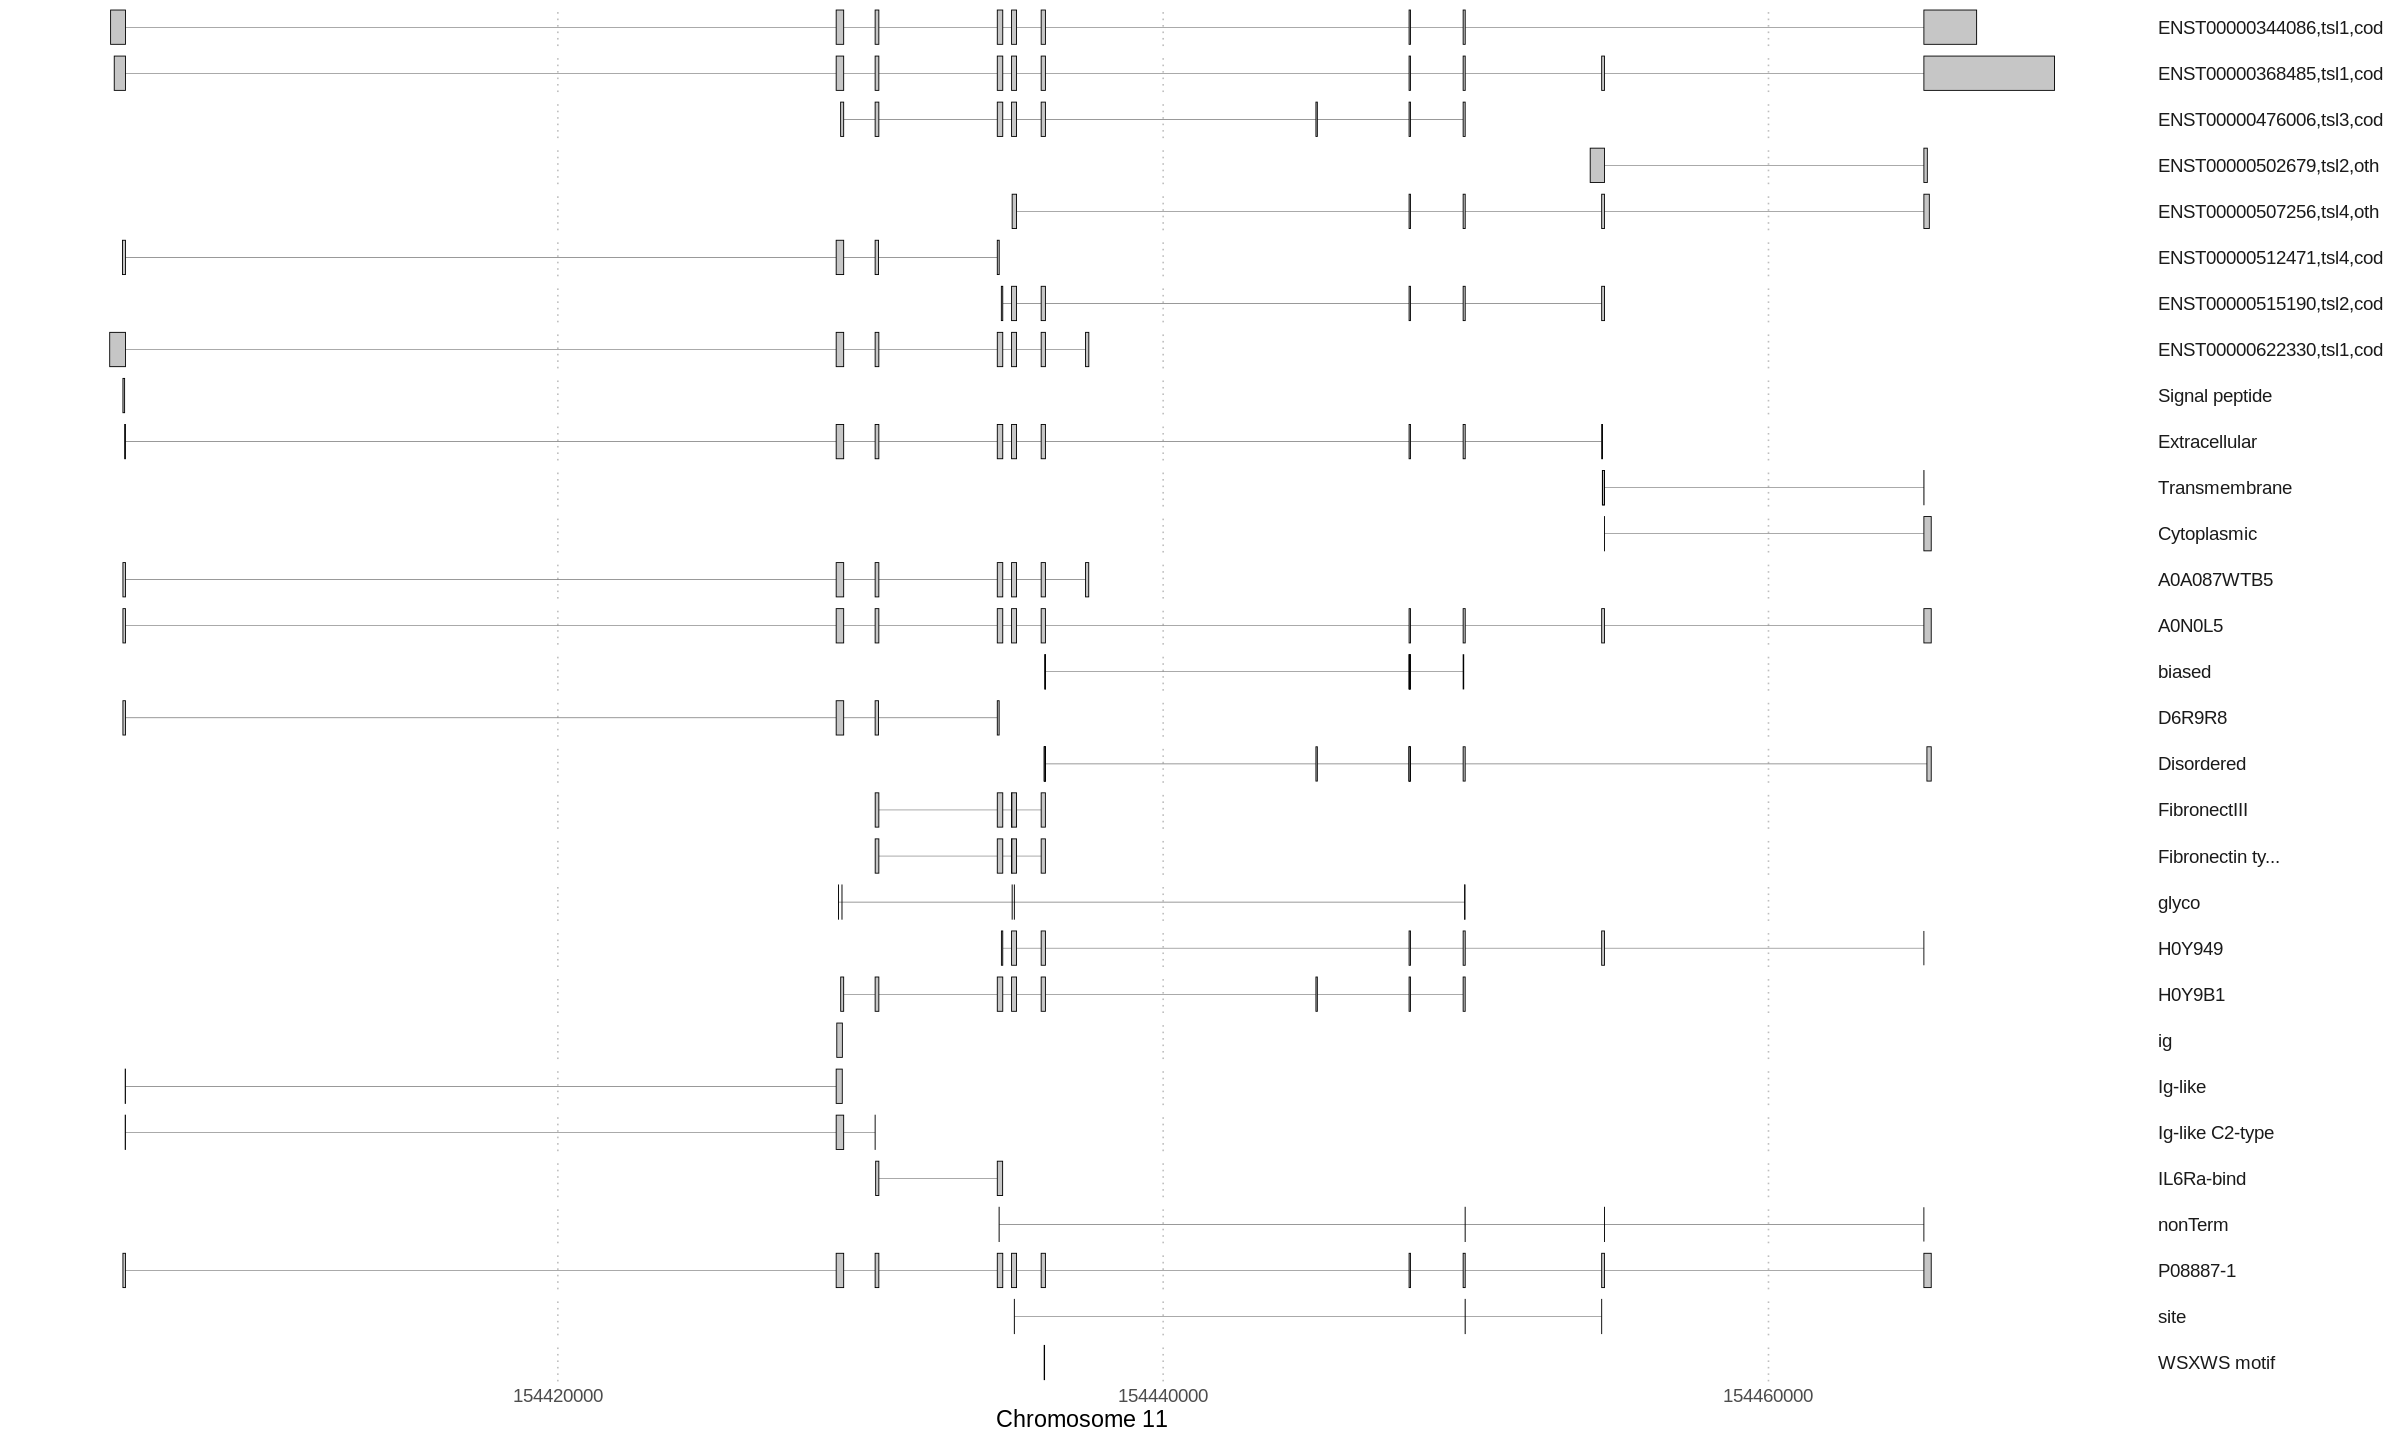

In [15]:
# Now, let's plot everything together!

transcript_domain_tb <-
bind_rows(
    il6r_transcripts_example_tb %>%
        mutate(track_type = "Transcripts") %>%
        rename(feature_name = transcript_label) %>%
        select(feature_name, start, end, strand, jstart, jend, track_type),
    il6r_domains_example_tb %>%
        mutate(track_type = "Domains") %>%
        rename(feature_name = domain_name) %>%
        select(feature_name, start, end, strand, jstart, jend, track_type)
) %>%
# Order transcripts on top, then domains
mutate(track_type = factor(track_type, levels = c("Transcripts", "Domains")))

transcript_domain_tb %>% 
plot_tracks(
    .,
    strand = "+",
    seqid = "Chromosome 11",
    add_connections = T,
    facet_wrap_by = "feature_name",
    intron_width=0.1
)  +
theme(
    text = element_text(size = 14),
    strip.text = element_text(hjust = 0),
    strip.background = element_rect(colour = "white",
                                    fill = "white"))


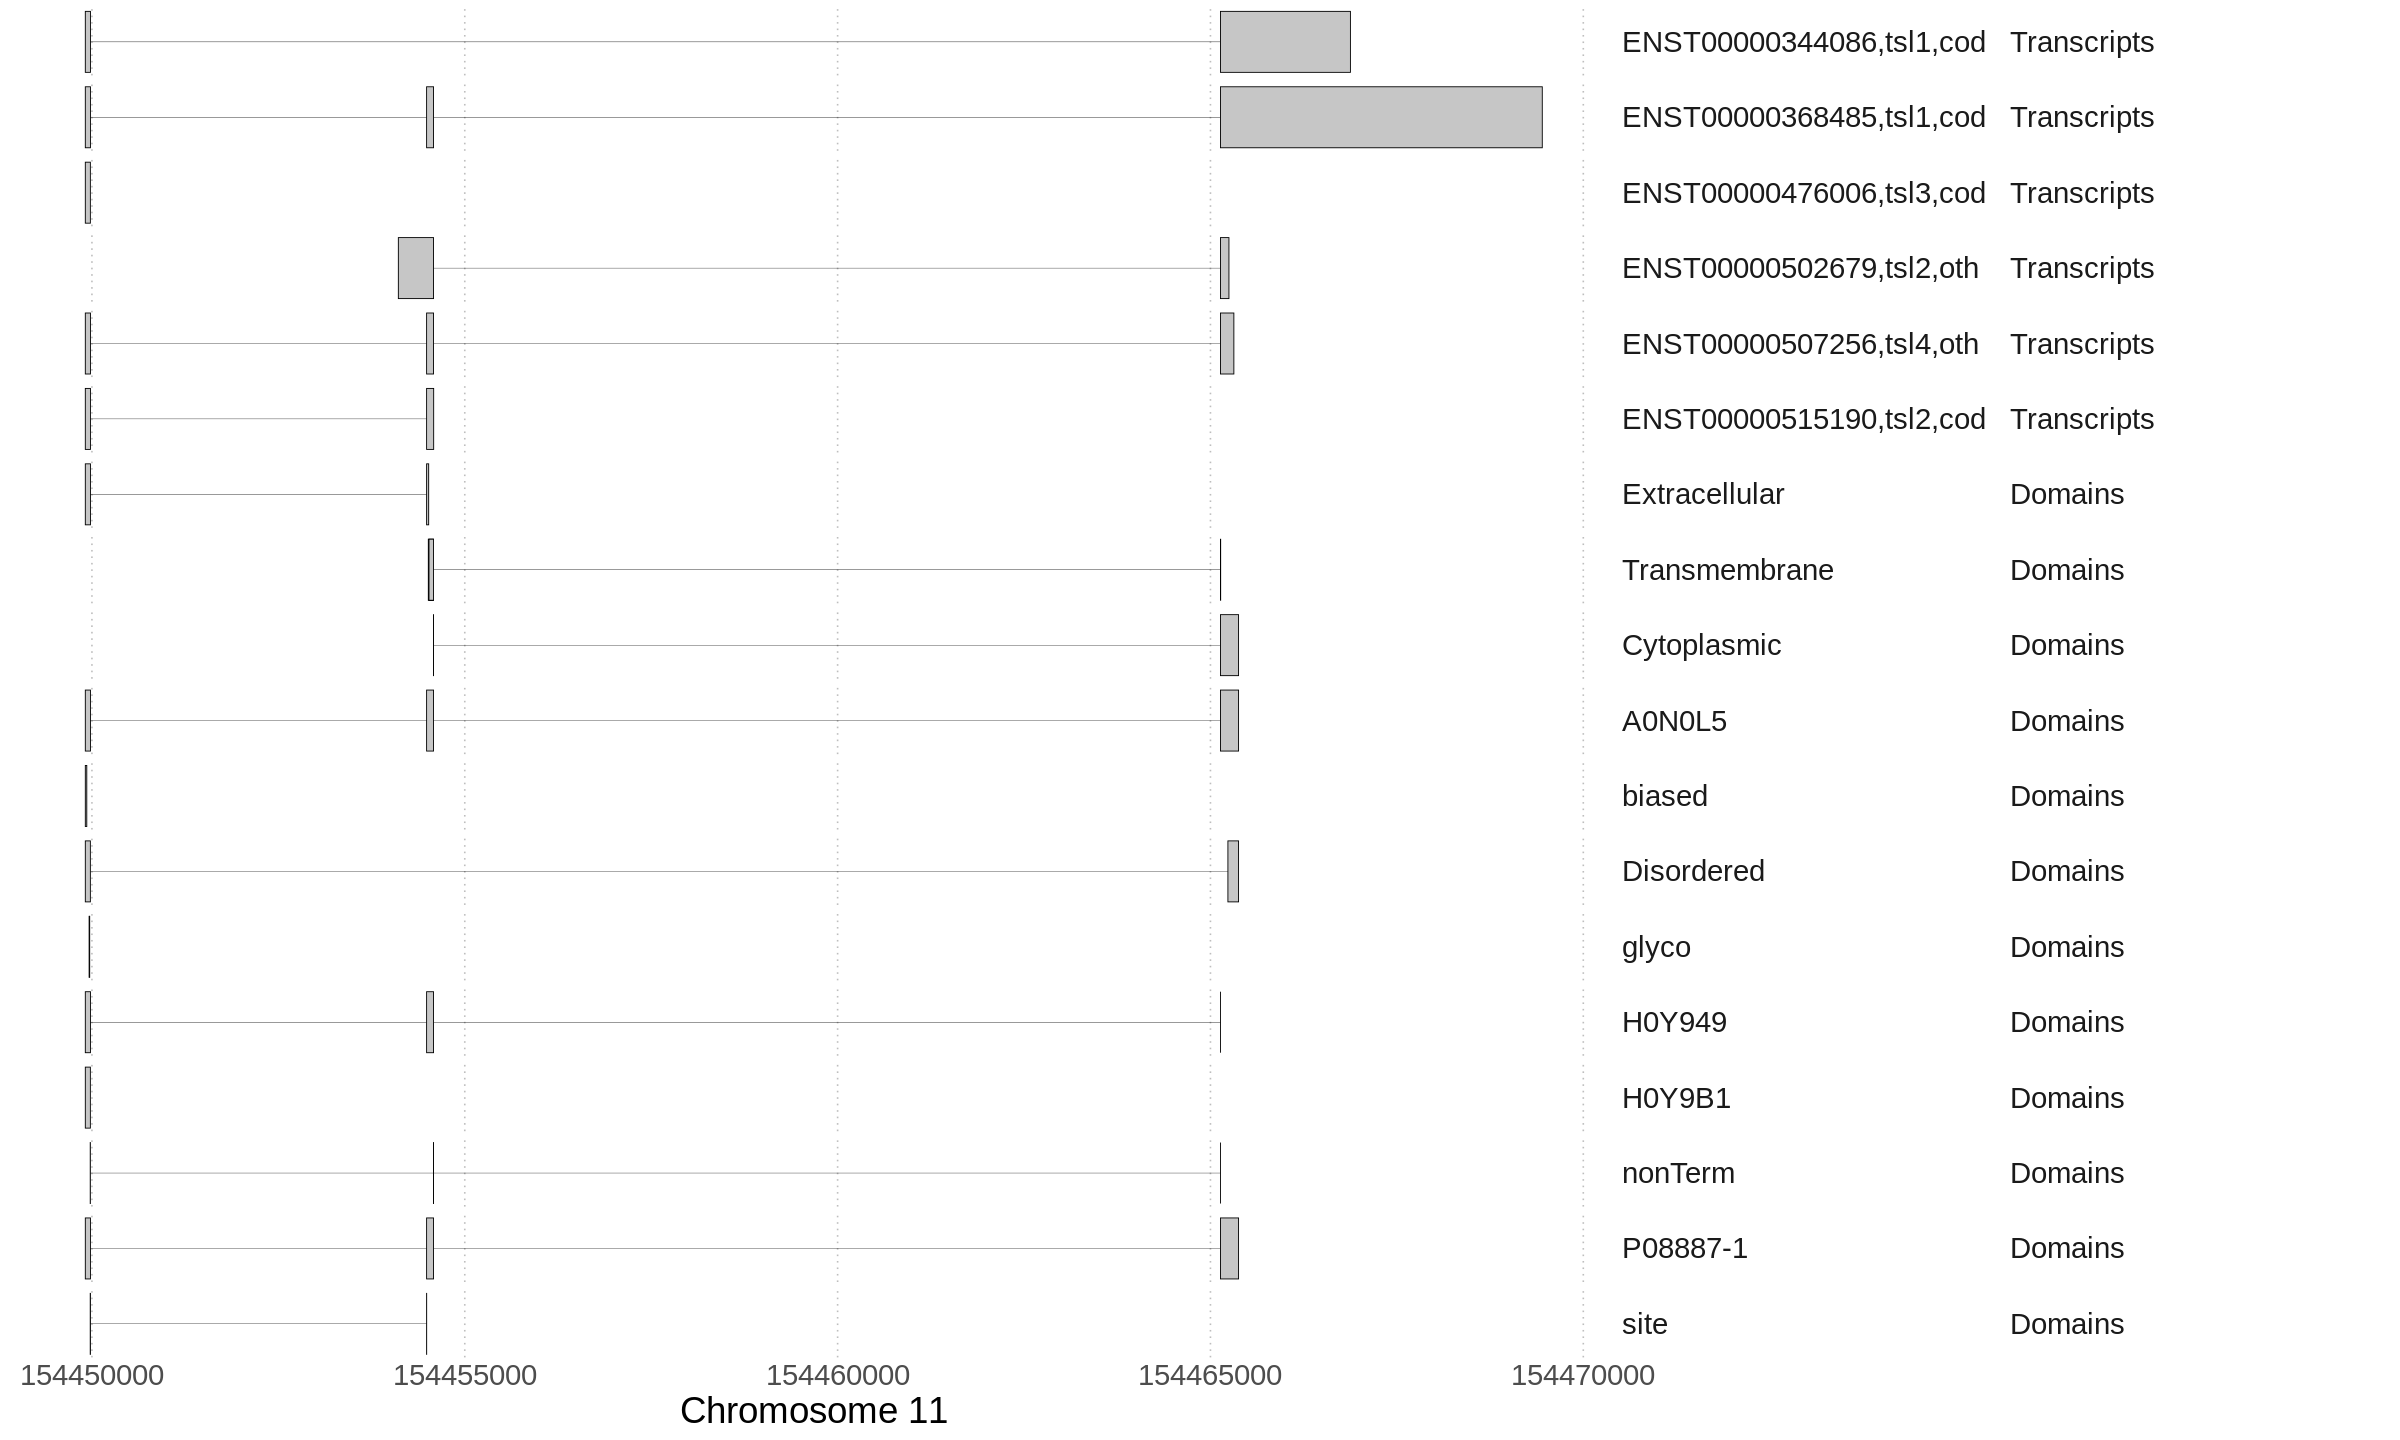

In [16]:
options(repr.plot.width=20, repr.plot.height=12)


# zoom in
transcript_domain_tb %>% 
filter(start >= 154449000 & end <= 154470000) %>%

plot_tracks(
    .,
    strand = "+",
    seqid = "Chromosome 11",
    add_connections = T,
    facet_wrap_by = "feature_name",
    intron_width=0.1
)  +
# Add the track_type
ggplot2::facet_wrap(
                track_type ~ feature_name,
                ncol = 1,
                strip.position = "right"
            ) +
theme(
    text = element_text(size = 22),
    strip.text = element_text(hjust = 0),
    strip.background = element_rect(colour = "white",
                                    fill = "white"))


In [17]:
custom_track_colors <- rep("red", length(levels(transcript_domain_tb$feature_name))) 
custom_track_colors[2] <- "blue"
names(custom_track_colors) <- levels(transcript_domain_tb$feature_name)

custom_track_colors



ENST00000344086,tsl1,cod ENST00000368485,tsl1,cod ENST00000476006,tsl3,cod 
                   "red"                   "blue"                    "red" 
ENST00000502679,tsl2,oth ENST00000507256,tsl4,oth ENST00000512471,tsl4,cod 
                   "red"                    "red"                    "red" 
ENST00000515190,tsl2,cod ENST00000622330,tsl1,cod          enzyme act site 
                   "red"                    "red"                    "red" 
          Signal peptide            Extracellular            Transmembrane 
                   "red"                    "red"                    "red" 
             Cytoplasmic               A0A087WTB5                   A0N0L5 
                   "red"                    "red"                    "red" 
                  biased                   D6R9R8               Disordered 
                   "red"                    "red"                    "red" 
            FibronectIII        Fibronectin ty...                    glyco 
                   "red"                    "red"                    "red" 
                  H0Y949                   H0Y9B1                       ig 
                   "red"                    "red"                    "red" 
                 Ig-like          Ig-like C2-type               IL6Ra-bind 
                   "red"                    "red"                    "red" 
                 nonTerm                 P08887-1                     site 
                   "red"                    "red"                    "red" 
             WSXWS motif 
                   "red"

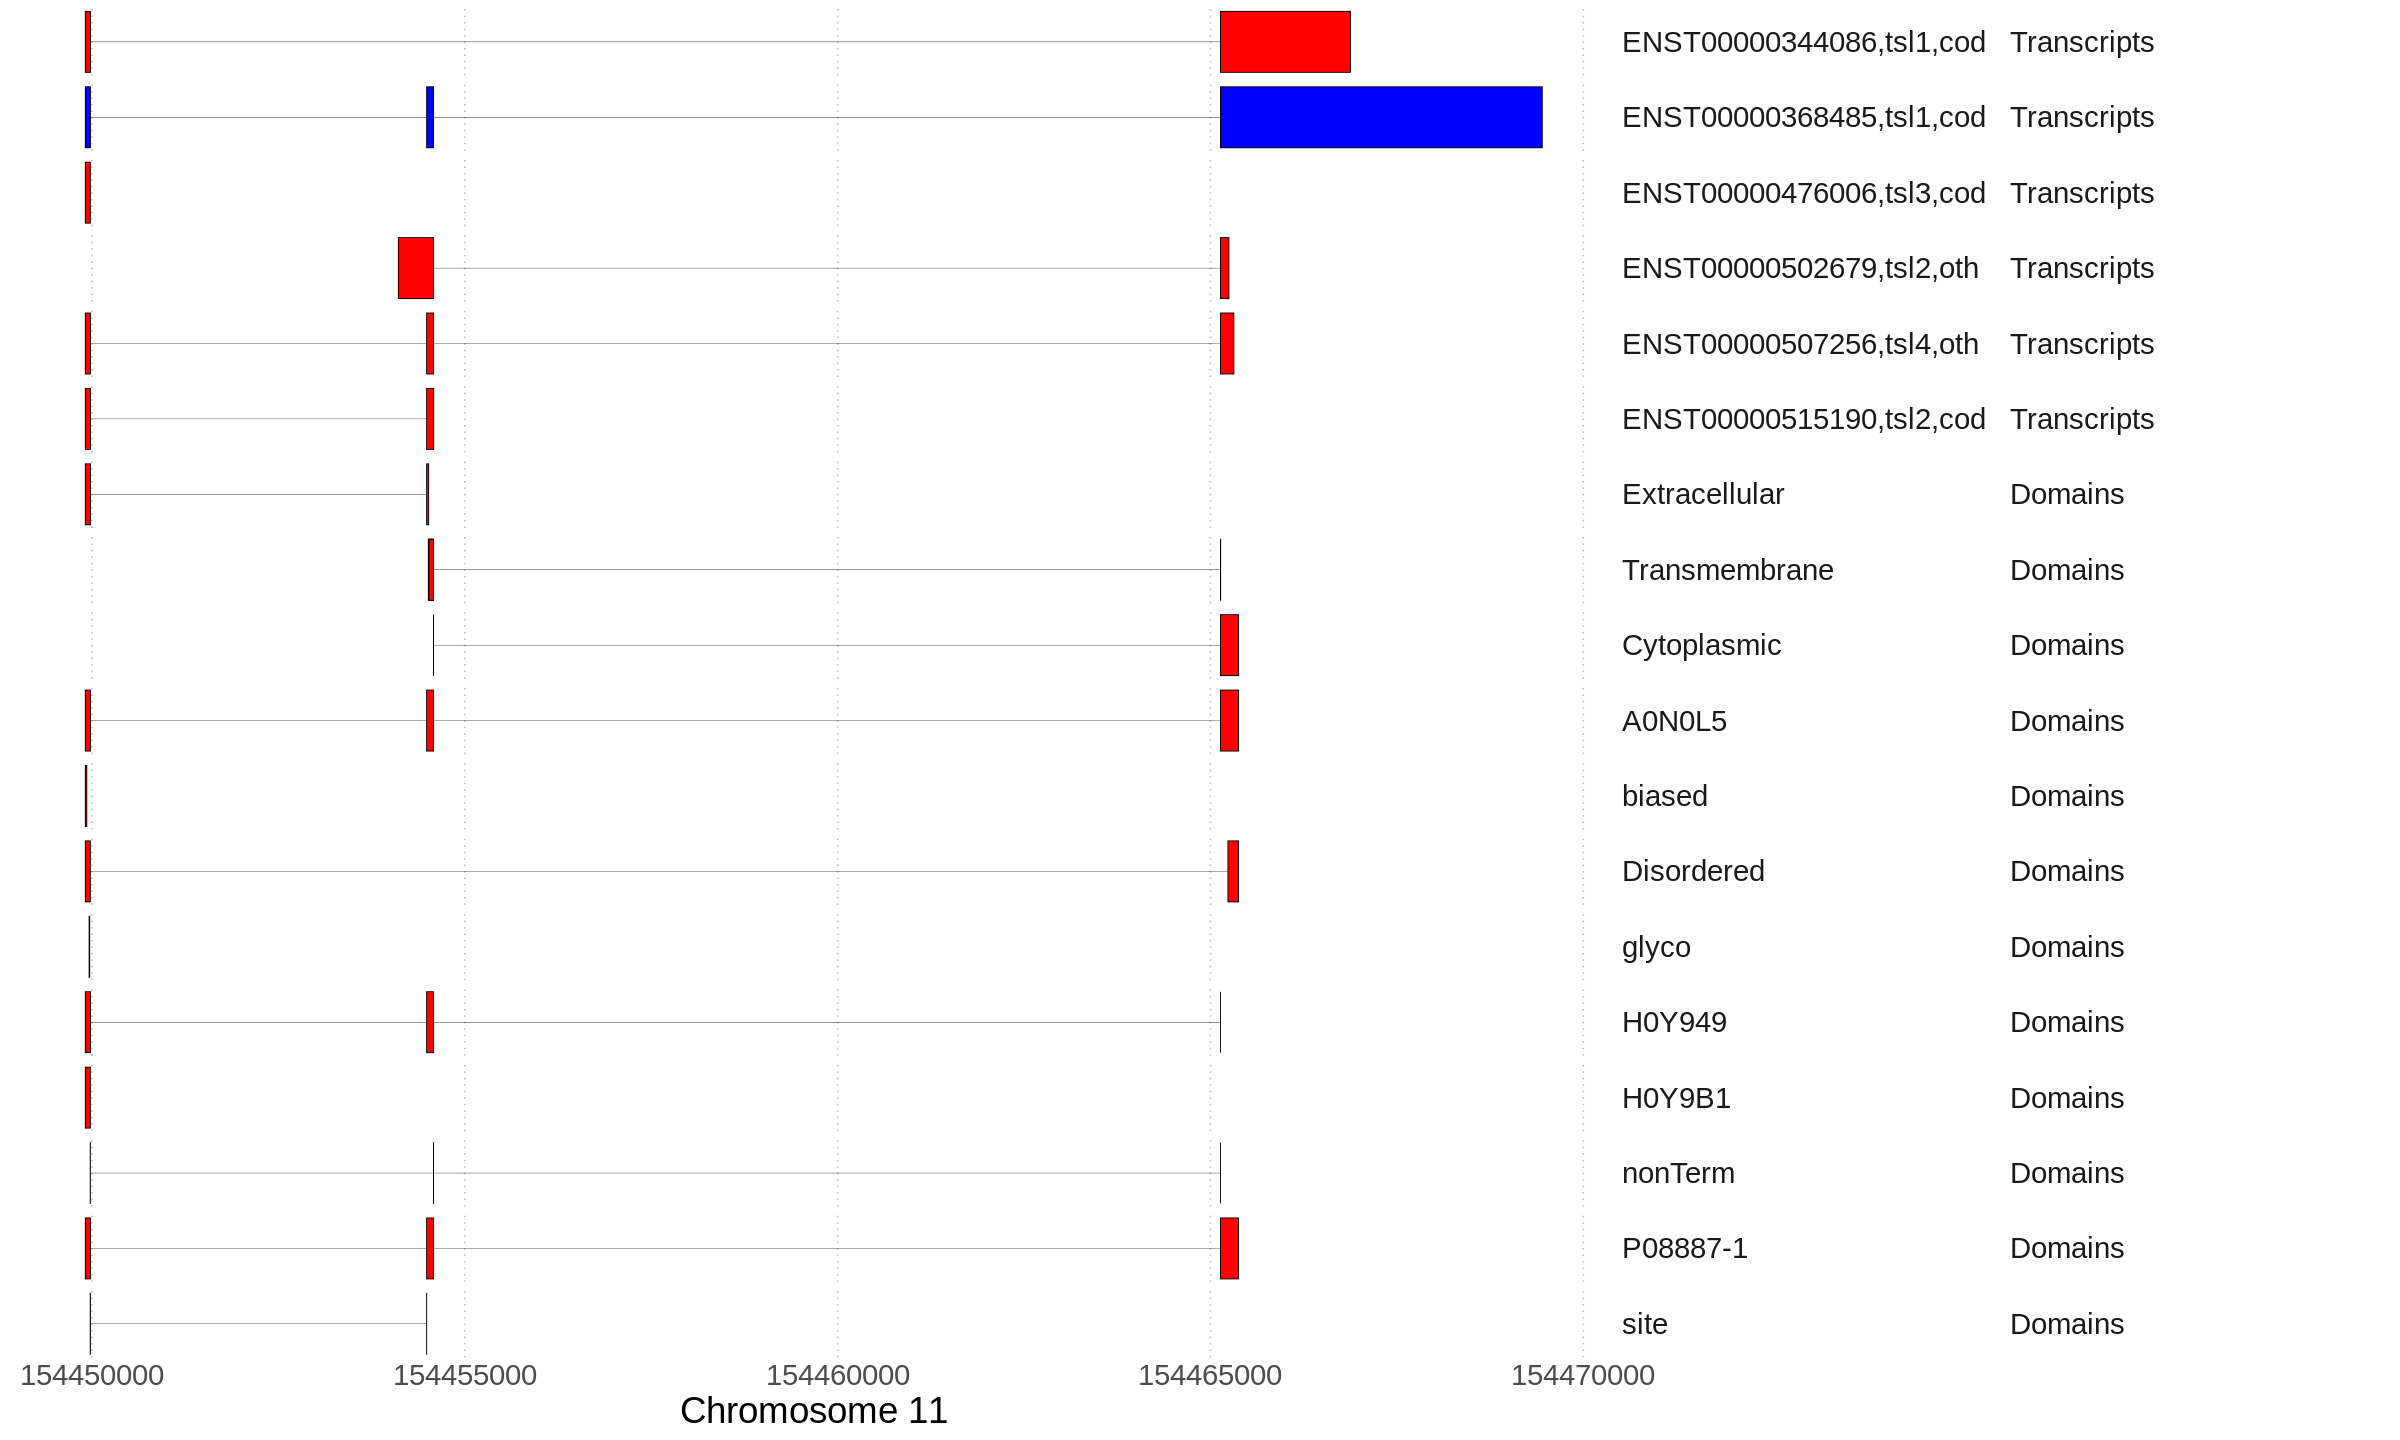

In [18]:
options(repr.plot.width=20, repr.plot.height=12)


# zoom in
transcript_domain_tb %>% 
filter(start >= 154449000 & end <= 154470000) %>%
plot_tracks(
    .,
    strand = "+",
    seqid = "Chromosome 11",
    add_connections = T,
    facet_wrap_by = "feature_name",
    intron_width=0.1,
    # turn on track colors. Adds AES element to fill `facet_wrap_by`
    color_tracks = TRUE
)  +
# Add the track_type
ggplot2::facet_wrap(
                track_type ~ feature_name,
                ncol = 1,
                strip.position = "right"
            ) +
theme(
    text = element_text(size = 22),
    strip.text = element_text(hjust = 0),
    strip.background = element_rect(colour = "white",
                                    fill = "white")) +
# customize fill colors
scale_fill_manual(values = custom_track_colors) +
# remove fill color guide legend
guides(fill=F)


In [41]:
levels(transcript_domain_tb$feature_name)

[1] "ENST00000344086,tsl1,cod" "ENST00000368485,tsl1,cod"
 [3] "ENST00000476006,tsl3,cod" "ENST00000502679,tsl2,oth"
 [5] "ENST00000507256,tsl4,oth" "ENST00000512471,tsl4,cod"
 [7] "ENST00000515190,tsl2,cod" "ENST00000622330,tsl1,cod"
 [9] "enzyme act site"          "Signal peptide"          
[11] "Extracellular"            "Transmembrane"           
[13] "Cytoplasmic"              "A0A087WTB5"              
[15] "A0N0L5"                   "biased"                  
[17] "D6R9R8"                   "Disordered"              
[19] "FibronectIII"             "Fibronectin ty..."       
[21] "glyco"                    "H0Y949"                  
[23] "H0Y9B1"                   "ig"                      
[25] "Ig-like"                  "Ig-like C2-type"         
[27] "IL6Ra-bind"               "nonTerm"                 
[29] "P08887-1"                 "site"                    
[31] "WSXWS motif"

In [47]:

# add a special track, ExonsOfINterest with a single
# row, 'my fav exon'
transcript_domain_tb_wfavexon <-
bind_rows(
    transcript_domain_tb,
    tibble(
        feature_name = "my fav exon",
        start = 154454488,
        end = 154454581,
        strand = "+",
        jstart = NA,
        jend = NA,
        track_type = "ExonsOfInterest"
    )
) %>%
mutate(
    # order the factor levels to make your fav exon on the top
    feature_name = factor(feature_name, levels = c("my fav exon", levels(transcript_domain_tb$feature_name))),
    track_type = factor(track_type, levels = c("ExonsOfInterest", levels(transcript_domain_tb$track_type)))
)

custom_track_colors <- rep("darkgrey", length(levels(transcript_domain_tb_wfavexon$feature_name))) 
names(custom_track_colors) <- levels(transcript_domain_tb_wfavexon$feature_name)
# color your fav exon blue
custom_track_colors[names(custom_track_colors) == "my fav exon"] <- "blue"
# also color the transcript of interest light blue
custom_track_colors[names(custom_track_colors) == "ENST00000368485,tsl1,cod"] <- "lightblue"
custom_track_colors

my fav exon ENST00000344086,tsl1,cod ENST00000368485,tsl1,cod 
                  "blue"               "darkgrey"              "lightblue" 
ENST00000476006,tsl3,cod ENST00000502679,tsl2,oth ENST00000507256,tsl4,oth 
              "darkgrey"               "darkgrey"               "darkgrey" 
ENST00000512471,tsl4,cod ENST00000515190,tsl2,cod ENST00000622330,tsl1,cod 
              "darkgrey"               "darkgrey"               "darkgrey" 
         enzyme act site           Signal peptide            Extracellular 
              "darkgrey"               "darkgrey"               "darkgrey" 
           Transmembrane              Cytoplasmic               A0A087WTB5 
              "darkgrey"               "darkgrey"               "darkgrey" 
                  A0N0L5                   biased                   D6R9R8 
              "darkgrey"               "darkgrey"               "darkgrey" 
              Disordered             FibronectIII        Fibronectin ty... 
              "darkgrey"               "darkgrey"               "darkgrey" 
                   glyco                   H0Y949                   H0Y9B1 
              "darkgrey"               "darkgrey"               "darkgrey" 
                      ig                  Ig-like          Ig-like C2-type 
              "darkgrey"               "darkgrey"               "darkgrey" 
              IL6Ra-bind                  nonTerm                 P08887-1 
              "darkgrey"               "darkgrey"               "darkgrey" 
                    site              WSXWS motif 
              "darkgrey"               "darkgrey"

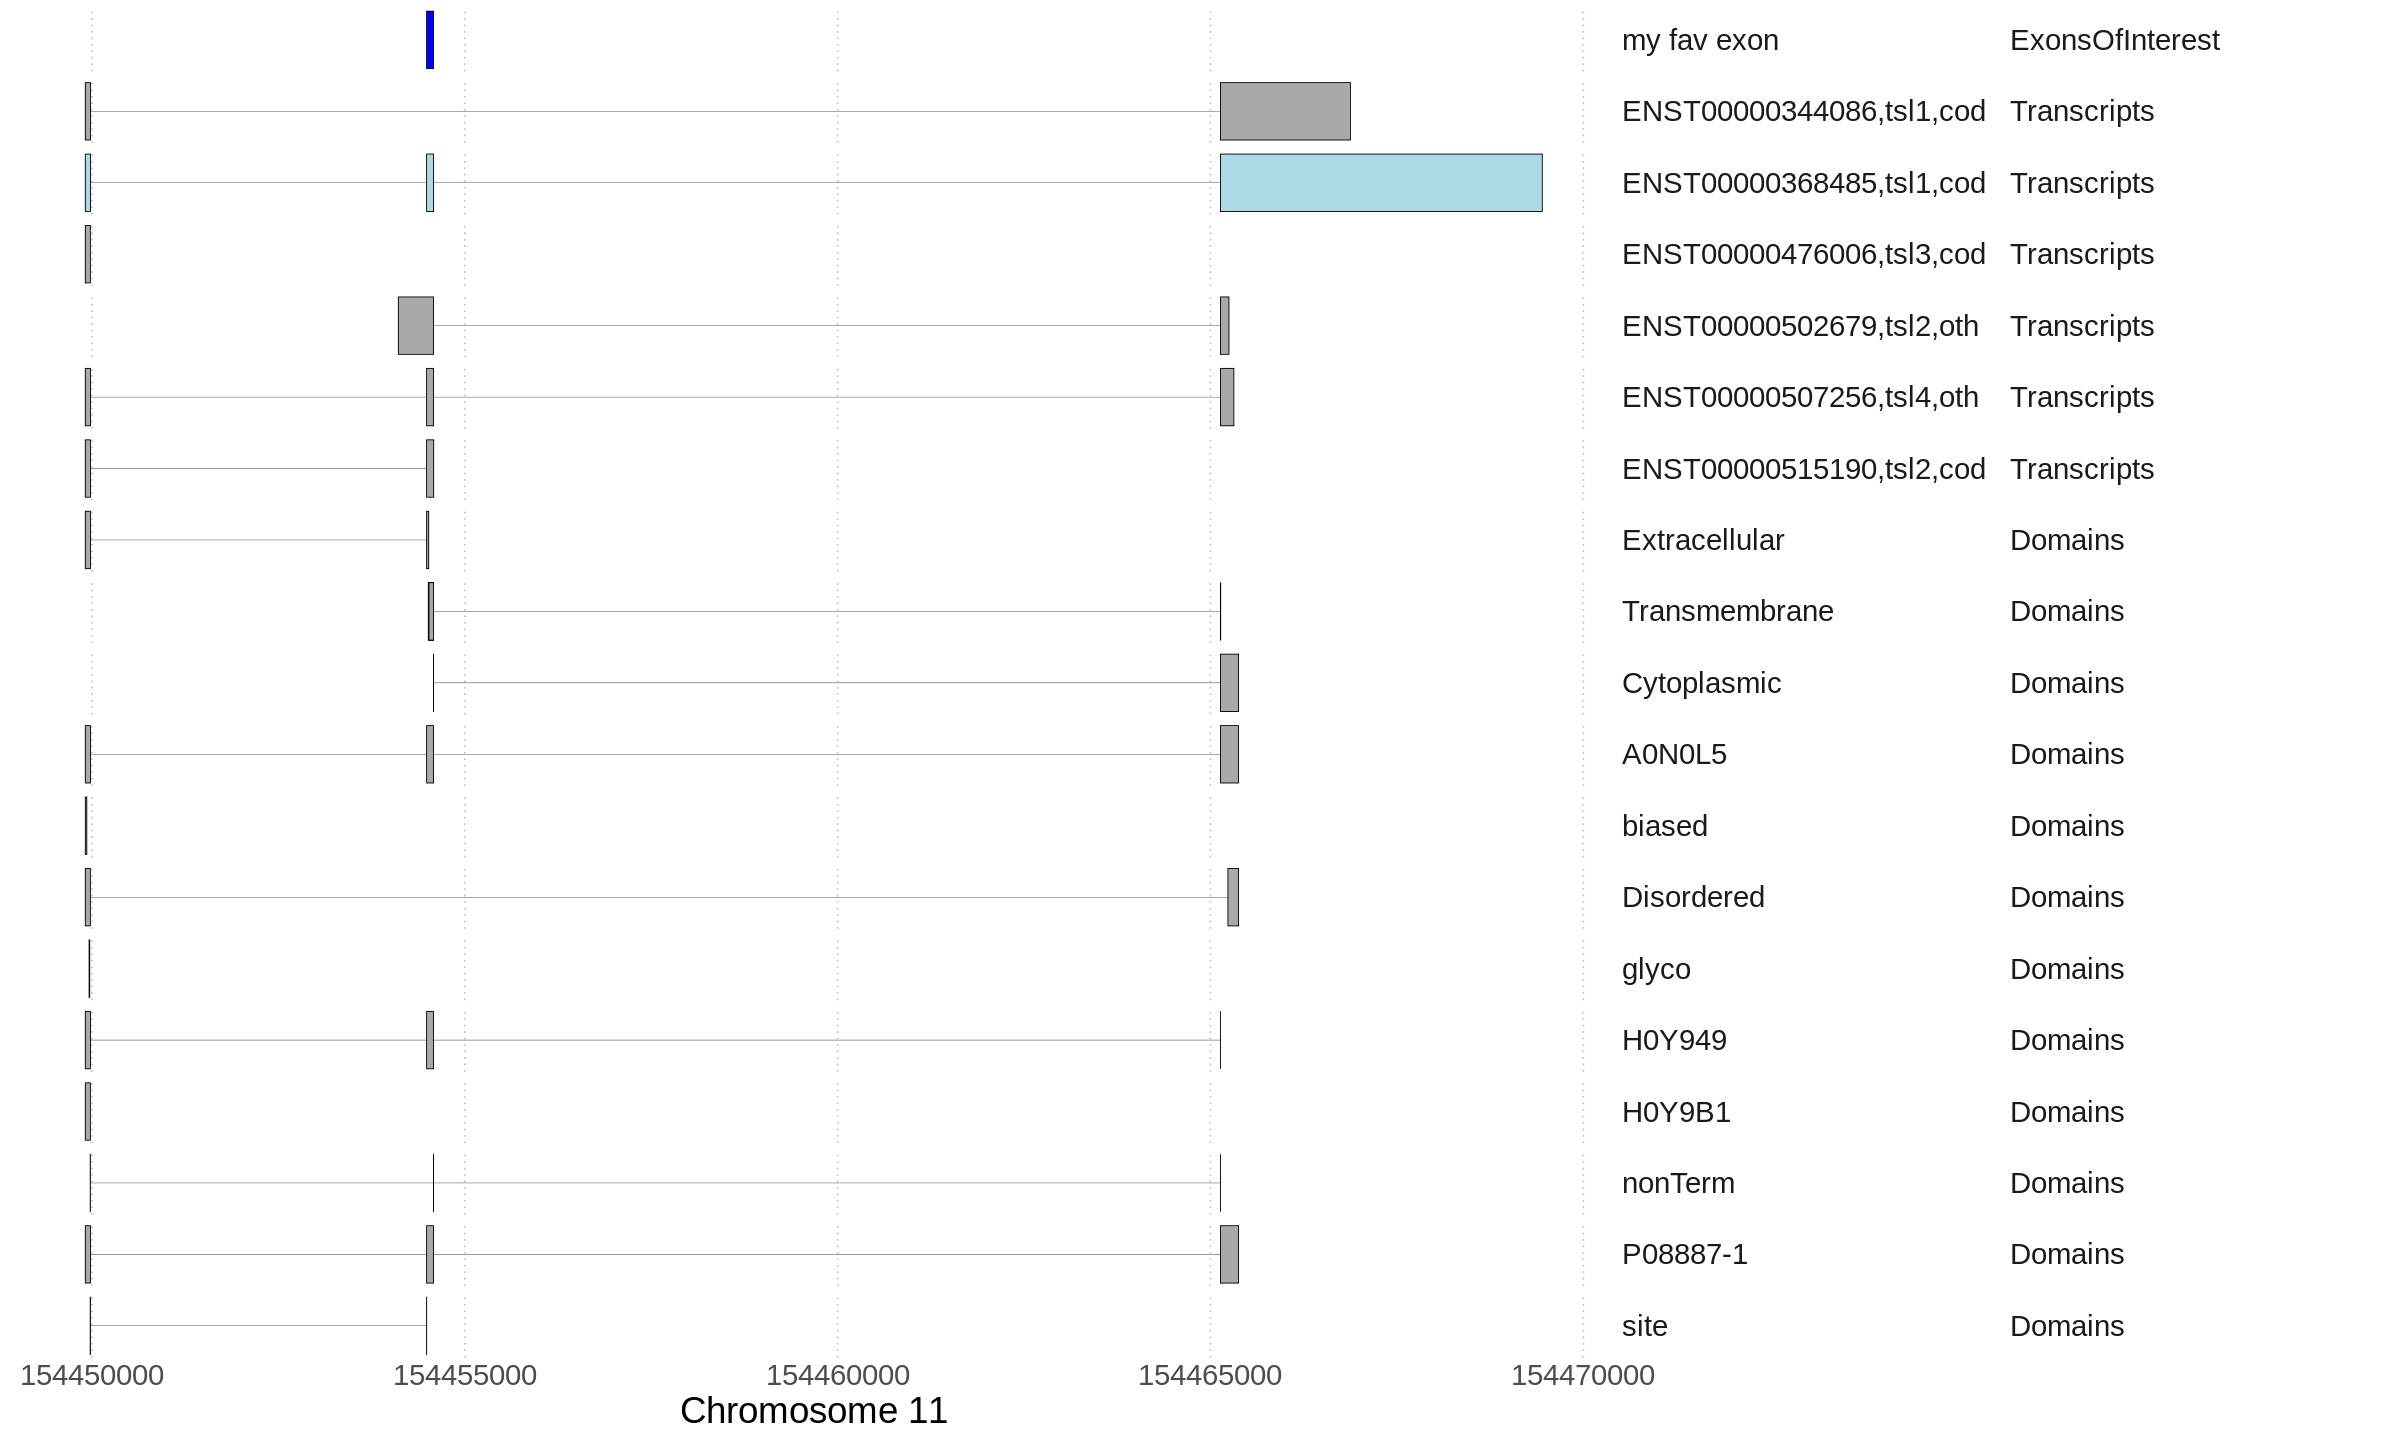

In [48]:
options(repr.plot.width=20, repr.plot.height=12)


transcript_domain_tb_wfavexon %>%
filter(start >= 154449000 & end <= 154470000) %>%
plot_tracks(
    .,
    strand = "+",
    seqid = "Chromosome 11",
    add_connections = T,
    facet_wrap_by = "feature_name",
    intron_width=0.1,
    # turn on track colors. Adds AES element to fill `facet_wrap_by`
    color_tracks = TRUE
)  +
# Add the track_type
ggplot2::facet_wrap(
                track_type ~ feature_name,
                ncol = 1,
                strip.position = "right"
            ) +
theme(
    text = element_text(size = 22),
    strip.text = element_text(hjust = 0),
    strip.background = element_rect(colour = "white",
                                    fill = "white")) +
# customize fill colors
scale_fill_manual(values = custom_track_colors) +
# remove fill color guide legend
guides(fill=F)


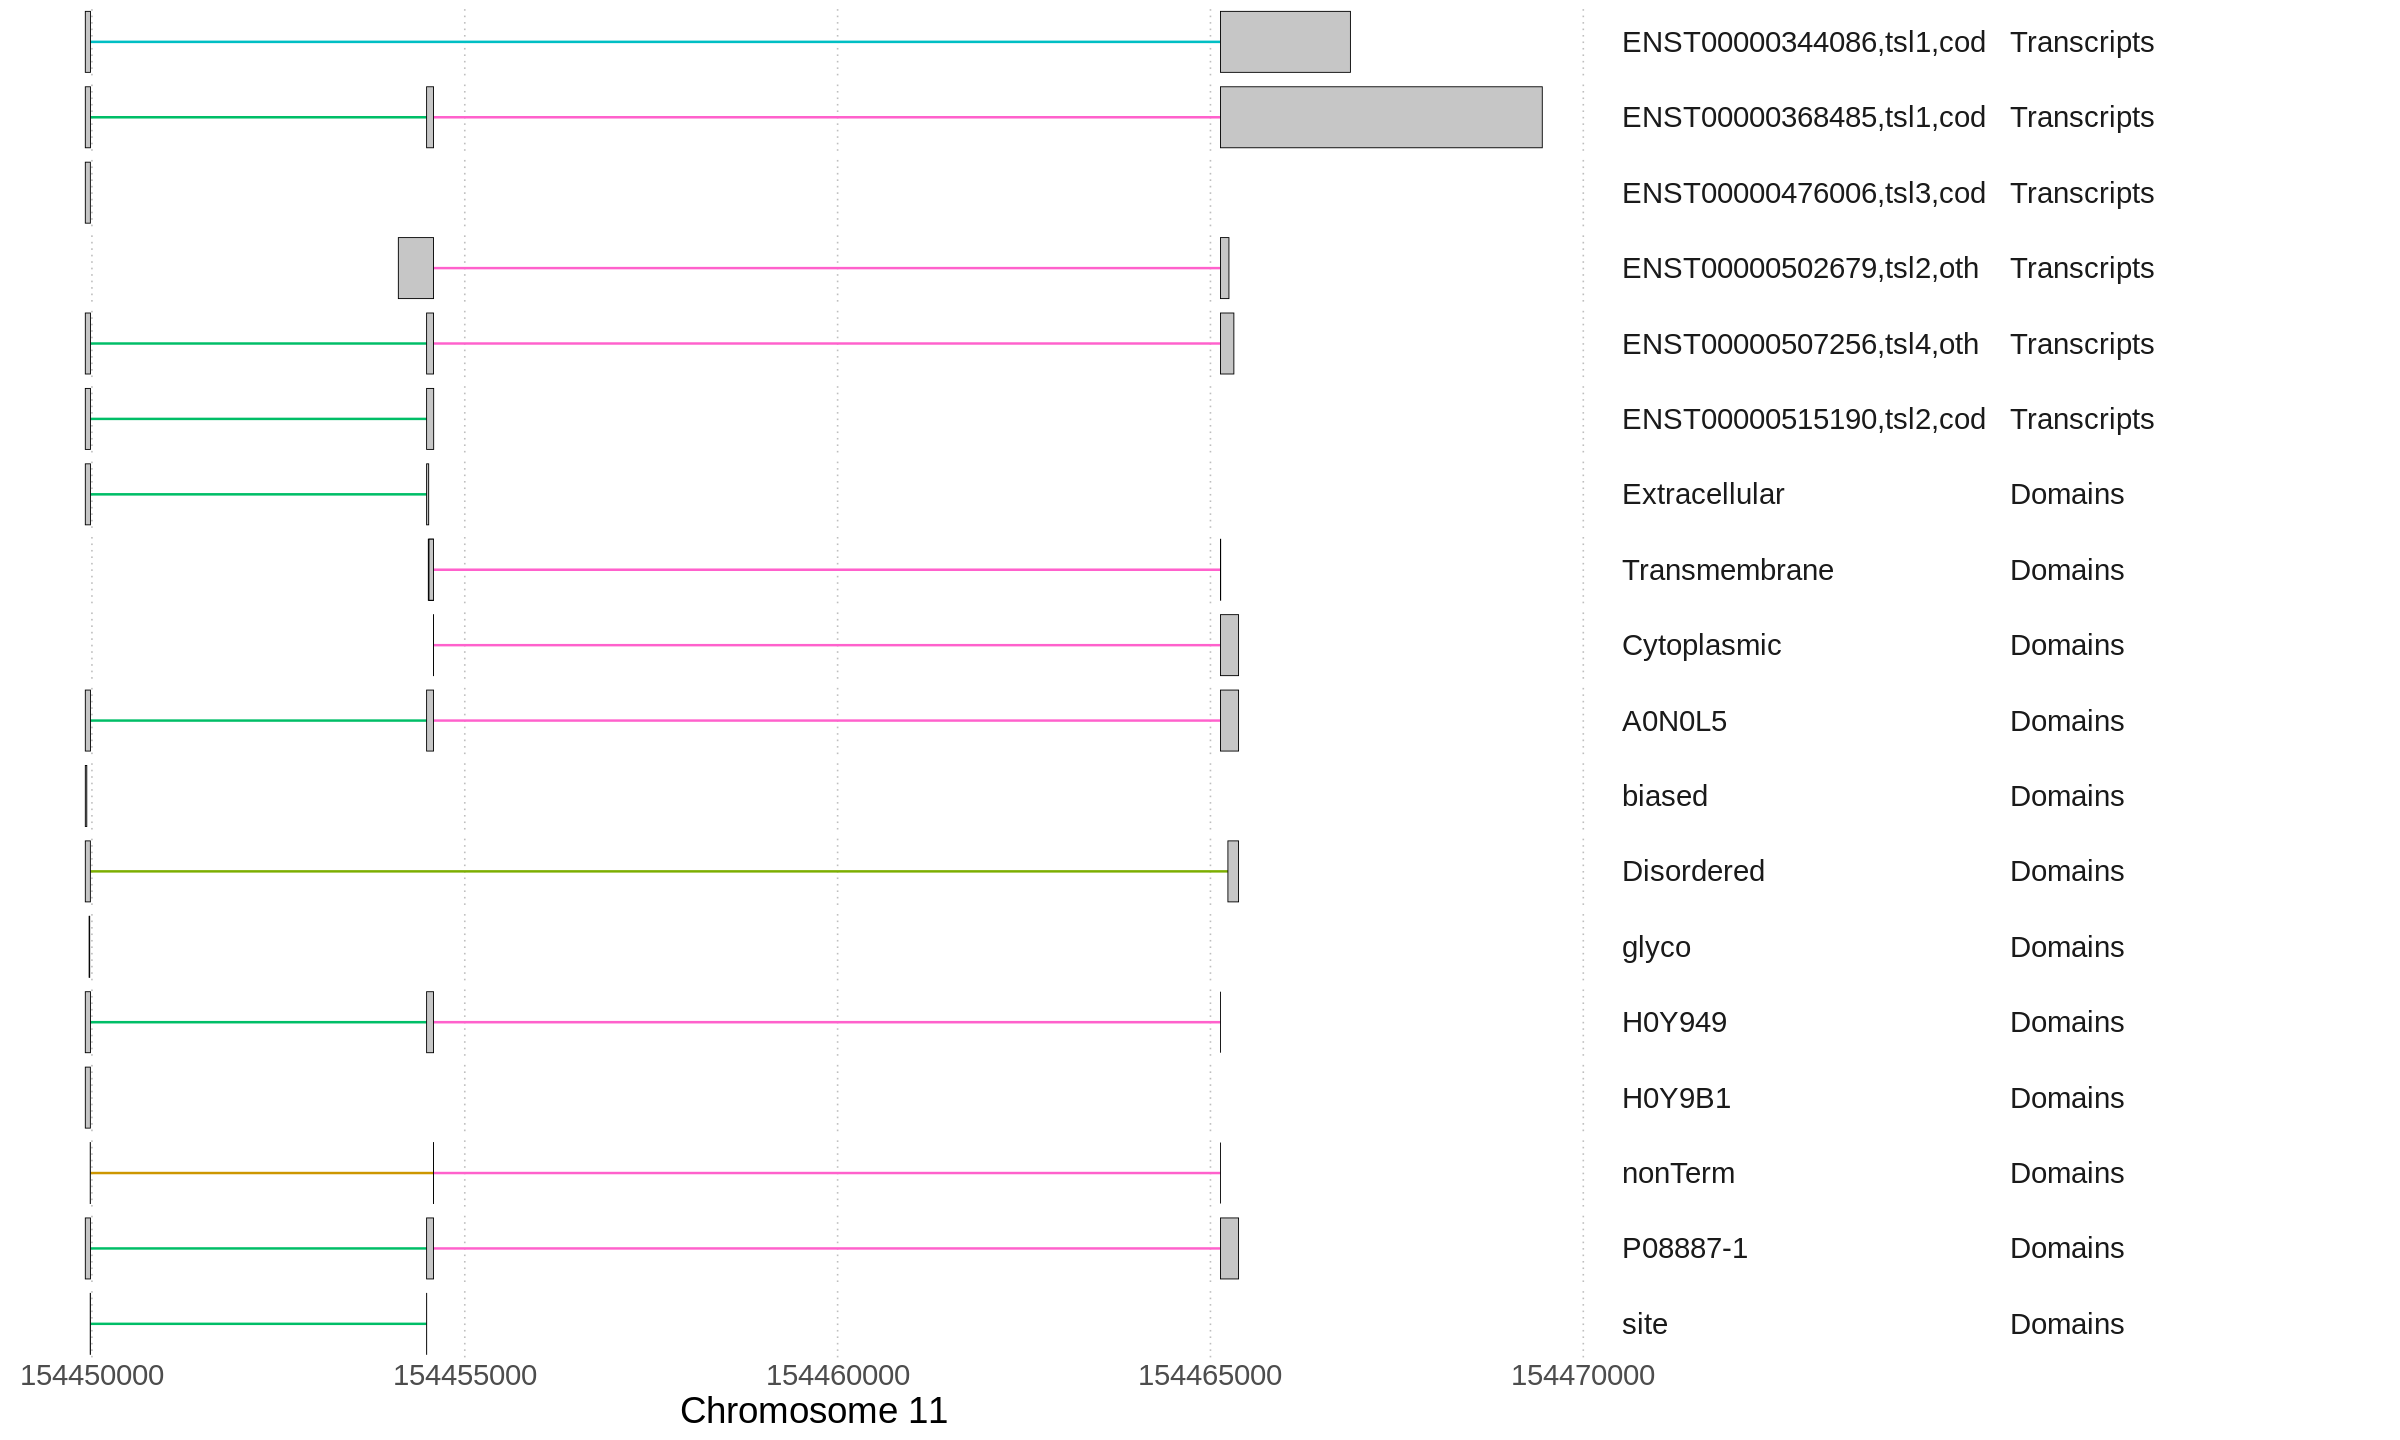

In [56]:
options(repr.plot.width=20, repr.plot.height=12)


# zoom in
transcript_domain_tb %>% 
filter(start >= 154449000 & end <= 154470000) %>%
plot_tracks(
    .,
    strand = "+",
    seqid = "Chromosome 11",
    add_connections = T,
    facet_wrap_by = "feature_name",
    # thicken the introns
    intron_width=0.7,
    # turn on intron colors. Adds AES element to color the intron start-ends
    color_connections = TRUE
)  +
# Add the track_type
ggplot2::facet_wrap(
                track_type ~ feature_name,
                ncol = 1,
                strip.position = "right"
            ) +
theme(
    text = element_text(size = 22),
    strip.text = element_text(hjust = 0),
    strip.background = element_rect(colour = "white",
                                    fill = "white")) +
# optionally add or remove color guide legend
guides(color=F)


In [57]:
#when add_connections=T, it adds jstart and jend using the function add_introns()
wintrons<-
transcript_domain_tb %>% 
    filter(start >= 154449000 & end <= 154470000) %>%
    # groupby here means the introns should connect exons grouped by transcript
    add_introns(groupby = c("feature_name")) %>%
    dplyr::mutate(junction = paste0(jstart, "-", jend))
wintrons
# show the IL6R transcript with the alt exon skipped
# filter(grepl("344086",feature_name))

feature_name,start,end,strand,jstart,jend,track_type,junction
<fct>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<fct>,<chr>
"ENST00000344086,tsl1,cod",154449911,154449980,+,154449980,154465134,Transcripts,154449980-154465134
"ENST00000344086,tsl1,cod",154465134,154466877,+,NA,NA,Transcripts,NA-NA
"ENST00000368485,tsl1,cod",154449911,154449980,+,154449980,154454488,Transcripts,154449980-154454488
"ENST00000368485,tsl1,cod",154454488,154454581,+,154454581,154465134,Transcripts,154454581-154465134
"ENST00000368485,tsl1,cod",154465134,154469450,+,NA,NA,Transcripts,NA-NA
"ENST00000476006,tsl3,cod",154449911,154449979,+,NA,NA,Transcripts,NA-NA
"ENST00000502679,tsl2,oth",154454109,154454581,+,154454581,154465134,Transcripts,154454581-154465134
"ENST00000502679,tsl2,oth",154465134,154465248,+,NA,NA,Transcripts,NA-NA
"ENST00000507256,tsl4,oth",154449911,154449980,+,154449980,154454488,Transcripts,154449980-154454488


In [58]:

uq_junctions <-
wintrons %>%
    filter(!is.na(jstart)) %>%
    distinct(junction) %>%
    pull(junction)

custom_intron_colors <- rep("grey", length(uq_junctions))
names(custom_intron_colors) <- uq_junctions

# make the junctions skipping your exon of intrest blue
custom_intron_colors[names(custom_intron_colors) %in% c("154454581-154465134")] <- "blue"
custom_intron_colors[names(custom_intron_colors) %in% c("154449980-154454488")] <- "lightblue"
custom_intron_colors[order(names(custom_intron_colors))]

154449964-154449968 154449979-154454580 154449979-154465234 154449980-154454488 
             "grey"              "grey"              "grey"         "lightblue" 
154449980-154465134 154454579-154454517 154454579-154454520 154454581-154465134 
             "grey"              "grey"              "grey"              "blue"

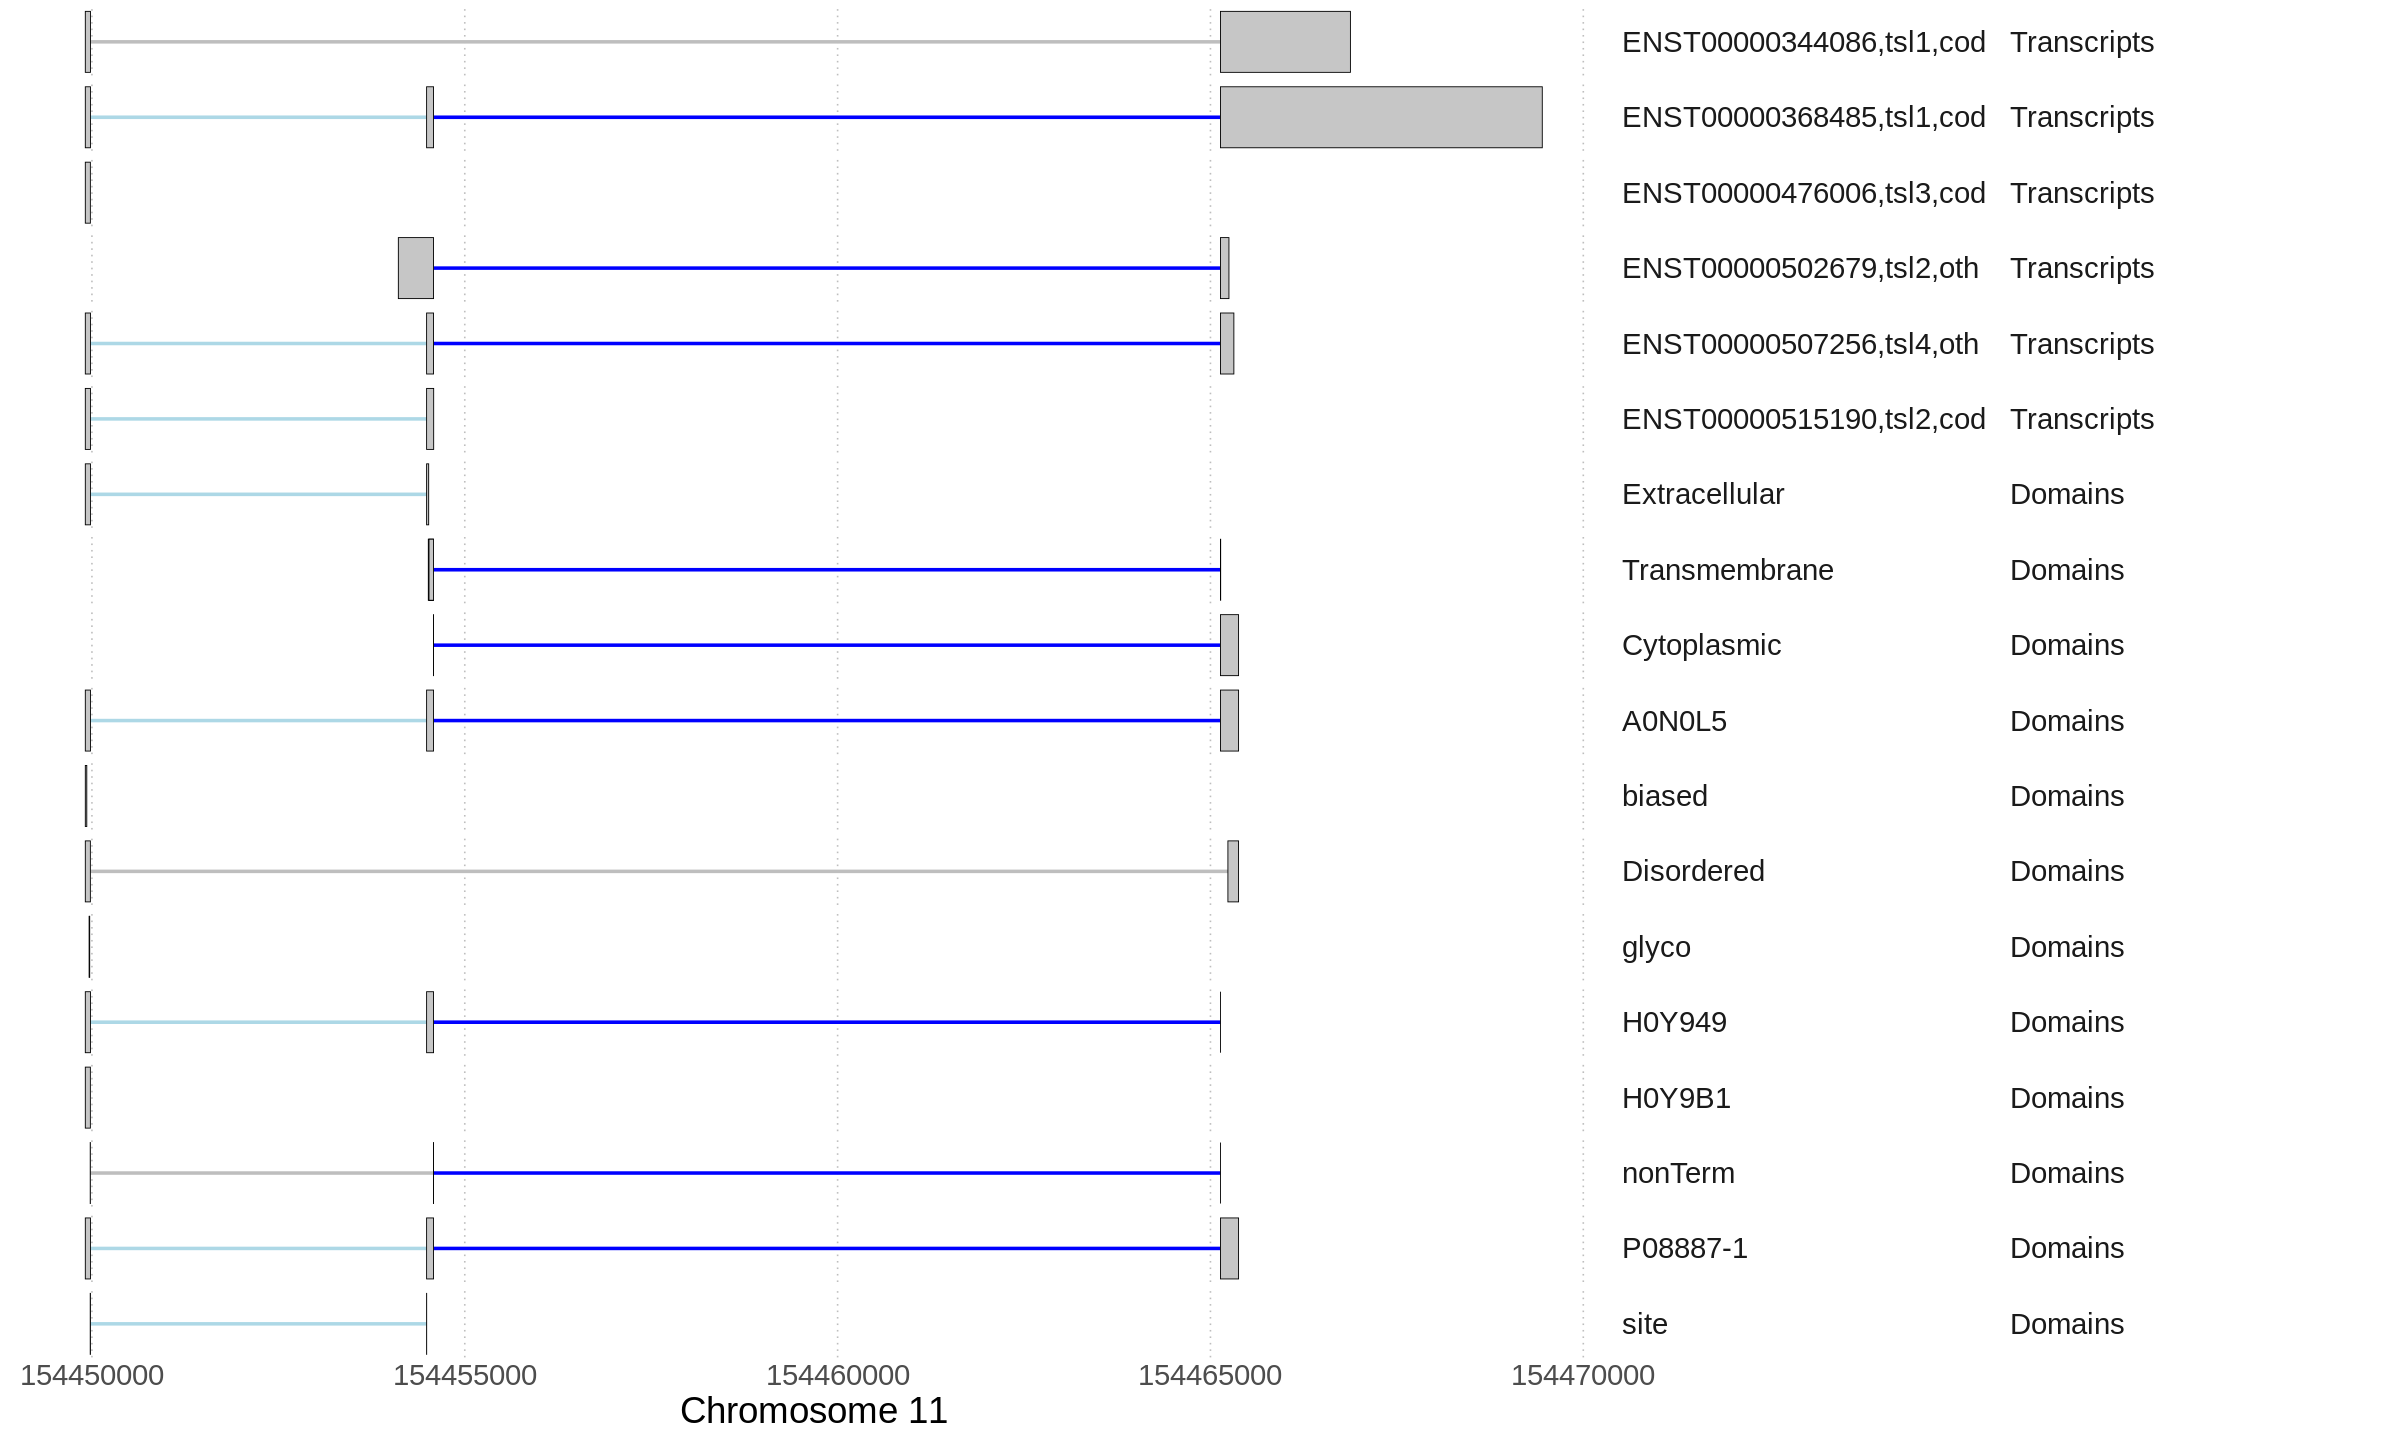

In [59]:
options(repr.plot.width=20, repr.plot.height=12)

source("gene_track_plots.R")
# zoom in
transcript_domain_tb %>% 
filter(start >= 154449000 & end <= 154470000) %>%
plot_tracks(
    .,
    strand = "+",
    seqid = "Chromosome 11",
    add_connections = T,
    facet_wrap_by = "feature_name",
    # thicken the introns
    intron_width=1,
    # turn on intron colors. Adds AES element to color the intron start-ends
    color_connections = TRUE
)  +
# Add the track_type
ggplot2::facet_wrap(
                track_type ~ feature_name,
                ncol = 1,
                strip.position = "right"
            ) +
theme(
    text = element_text(size = 22),
    strip.text = element_text(hjust = 0),
    strip.background = element_rect(colour = "white",
                                    fill = "white")) +
# customize intron colors
scale_color_manual(values = custom_intron_colors) +
# remove fill color guide legend
guides(color=F)


In [61]:
print("done")

[1] "done"
